<font size="6"><b>UNet Tutorial:</b></font>
<ol start="0">
<font size="4"><b>0. <a href='#0'>Pre-Tutorial</a></b> 
    <ul>
    <b>0.1</b> <a href="#0.1">Getting Some Things Set Up </a>  
    </ul>
    <ul>
    <b>0.2</b> <a href='#0.2'>What is a UNet?</a>
    </ul>
    <ul>
    </ul>
   
<font size="4"><b>1. <a href='#1'>How Convolutions Work</a></b></font>
    <ul>
    <b>1.1</b> <a href='#1.1'>The Convolution Operation</a>  
    </ul>
    <ul>
    <b>1.2</b> <a href='#1.2'>Convolving an Image</a>
    </ul>
    <ul>
    <b>1.3</b> <a href='#1.3'>Padding</a>
    </ul>
    <ul>
    <b>1.4</b> <a href='#1.4'>Bias Additions and Activations</a>
    </ul>
    <ul>
    </ul>

<font size="4"><b>2. <a href='#2'>How Filters Transform Images</a></b></font>
    <ul>
    <b>2.1</b> <a href='#2.1'>The Horizontal Edge Detector</a>  
    </ul>
    <ul>
    <b>2.2</b> <a href='#2.2'>The Horizontal Edge Detector in Action</a> 
    </ul> 
    <ul>
    </ul>

<font size="4"><b>3. <a href='#3'>The UNet Architecture</a></b></font>
    <ul> 
    <b>3.1</b> <a href='#3.1'>The UNet Structure</a>  
    </ul>
    <ul>
    <b>3.2</b> <a href='#3.2'>Convolutional Layers</a> 
    <ul>
    <b>3.2.1</b> <a href='#3.2'>Bonus: 3D Convolutions</a> 
    </ul>
    </ul>
    <ul> 
    <b>3.3</b> <a href='#3.3'>Pooling Layers</a>  
    </ul>
    <ul>
    <b>3.4</b> <a href='#3.4'>Upsampling Layers</a> 
    </ul>
    <ul> 
    <b>3.5</b> <a href='#3.5'>Concatenations</a> 
    </ul>
    <ul>
    </ul>

<font size="4"><b>4. <a href='#4'>A Very Simple Example</a></b></font>
    <ul>
    <b>4.1</b> <a href='#4.1'>The Data/Problem</a>  
    </ul>
    <ul>
    <b>4.2</b> <a href='#4.2'>The Architecture</a>  
    </ul>
    <ul>
    <b>4.3</b> <a href='#4.3'>Conv Block #1</a>  
    </ul>
    <ul>
    <b>4.4</b> <a href='#4.4'>Conv Block #2</a> 
    </ul>
    <ul> 
    <b>4.5</b> <a href='#4.5'>UpConv Block #1</a> 
    </ul>
    <ul> 
    <b>4.6</b> <a href='#4.6'>UpConv Block #2</a>  
    </ul>
    <ul> 
    <b>4.7</b> <a href='#4.7'>The Final Model</a>  
    </ul>
    <ul>
    </ul>
    
<font size="4"><b>5. <a href='#5'>Interpreting Filters</a></b></font>
    <ul>
    <b>5.1</b> <a href='#5.1'>Our Simple Example</a>  
    </ul>
    <ul>
    <b>5.2</b> <a href='#5.1'>A Real-World Example</a>  
    </ul>
    <ul>
    <b>5.4</b> <a href='#5.3'>Deeper Layers</a> 
    </ul>
    <ul>
    </ul>
</ol>

<font size="5">**0. Pre-Tutorial**</font>
<a id='#0'></a>

Before we start, let's check that the GPU is ready to go if we have one, and import packages that we'll need, and talk about the motivations behind using a U-Net

<a id="0.1"></a>
<font size="4">**0.1 Some Setup**



We'll start by importing the packages we'll need, and define a string which is just the path to the folder that contains this notebook as well as all of the other images/data needed to run it (should be in folders as they are on github).

In [8]:
!pip install -q keras
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf

from PIL import Image

from matplotlib import animation
from IPython.display import display, HTML
from IPython.display import Image as Im

#filepath = '/content/gdrive/My Drive/UNet_Tutorial'   # what my path is on Google Drive
filepath = '.'    # what my path is when I'm on local, for example, because the notebook is in the same directory 
                  # as all of the directories with the data/images (same file strucutre as on github)

<a id="0.2"></a>
<font size="4">**0.2 What is a UNet?**</font>


You might be wondering: what exactly is a UNet? Why would I want to use one? How is it different from other convolutional neural nets? So we'll start by giving a bit of motivation for why UNets are so useful.

Let's say we have an image.

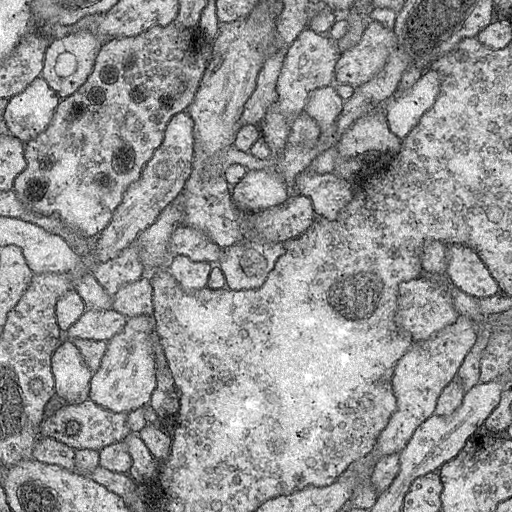

In [9]:
display(Im('%s/data/test_input.png' %filepath, height=270, width=270))

A "normal" CNN task might be to say "that's a stomach" given that the image could have been from a stomach, brain, or skin. (Full disclosure: I don't know what this image is of, but it's a medical image of some sort).

Let's say instead though, that we want this:

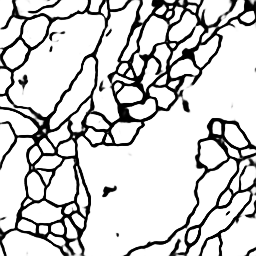

In [10]:
display(Im('%s/data/test_output.png' %filepath, height=270, width=270))

That's not a single class output: it's another image. And "normal" CNN's don't give an image from an image, they collapse an image into one number or one set of numbers. Enter the UNet. Fundamentally, it's a CNN that's architecture is such that you get an image back out of the same size as the input image.

One way to think about this is really as pixel-by-pixel classification: in the above example, we're deciding whether each pixel should be assigned black or white. But as you'll see, a UNet is more generalizable than that, and the final image doesn't necessarily need to correspond to pixel classifications.

<a id="1"></a>
<font size="5">**1. How Convolutions Work**</font>

UNets are a type of convolutional neural network (CNN), so understanding how convolutions work is fundamental to understanding how these networks work. In this section, we briefly go over how to perform convolutions and the building blocks of a convolutional layer in a CNN. While I cover all the basics here, this is meant as more of a refresher and assumes you have previously seen how a convolutional network works (but may have forgotten the details since).

<a id="1.1"></a>
<font size="4">**1.1 The Convolution Operation**</font>

First, we need to cover exactly what a "convolution" means. The building blocks of convolutions are essentially dot products over matricies - we multiply the values in a matrix by the corresponding values in another matrix, then add the values together to get a number.

Let's define matricies A and B, then take the dot product between them.

17


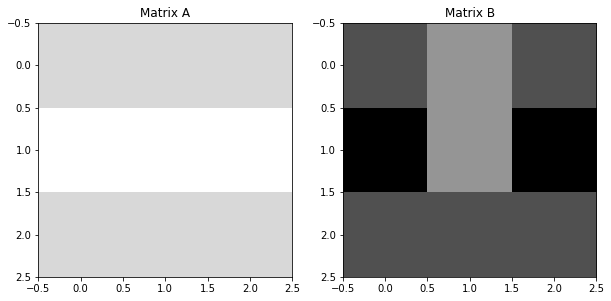

In [3]:
a = np.array([[1,1,1],[0,0,0],[1,1,1]])
b = np.array([[3,2,3],[4,2,4],[3,3,3]])

# to visualize the matricies
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(a, vmin=0, vmax=4, cmap="Greys"), ax1.set_title("Matrix A")
ax2.imshow(b, vmin=0, vmax=4, cmap="Greys"), ax2.set_title("Matrix B")

print(np.sum(a*b)) # since a/b are arrays, a*b is element-wise multiplication

Note that, this is different than doing matrix multiplication, which would result in another matrix, rather than just one number.

Really, we want to think of this operation as giving us some linear combination of a matrix. If we want a linear combination of matrix X with values *x1,x2,x3, ... x9*, we can define some matrix A with values *a,b,c, ... i*, such that:

\begin{equation*}
y = \begin{bmatrix}a&b&c\\d&e&f\\g&h&i\end{bmatrix} * \begin{bmatrix}x_1&x_2&x_3\\x_4&x_5&x_6\\x_7&x_8&x_9\end{bmatrix} = (a \times x_1) + (b \times x_2) + (c \times x_3) + (d \times x_4) + (e \times x_5) + (f \times x_6) + (g \times x_7) + (h \times x_8) + (i \times x_9)
\end{equation*}

Then, we can interpret the values in matrix A (*a,b,c, ... i*) as **weights**, each of which decides how strong the contribution from matrix X's values (*x1,x2,x3, ... x9*) should be.

<a id='#1.2'></a>
**<font size="4"> 1.2 Convolving an Image**</font>

When we convolve an image, we simply perform this operation over and over again, on each pixel of an image. So, matrix A would be our matrix of weights, and matrix X is a matrix of pixel values, where the center value is our current pixel of interest. Convolving an image means performing this operation on every pixel of the image, then replacing its value with the one that is given by our matrix dot product. In this way, the image becomes another version of itself - one where each pixel is some linear combination of the pixels that were around it:

\begin{equation*}
\color{red}{x_{5,new}} = \begin{bmatrix}a&b&c\\d&e&f\\g&h&i\end{bmatrix} \times \begin{bmatrix}x_1&x_2&x_3\\x_4&\color{red}{x_5}&x_6\\x_7&x_8&x_9\end{bmatrix} = (a \times x_1) + (b \times x_2) + (c \times x_3) + (d \times x_4) + (e \times x_5) + (f \times x_6) + (g \times x_7) + (h \times x_8) + (i \times x_9)
\end{equation*}

In convolutional network applications, we typically call this matrix of weights a **filter**. In other applications that use convolutions, it may also be called a **kernel**.

Let's use matrix A from before, this time to convolve a simple, 5x5 image. The image we are going to convolve is shown below:

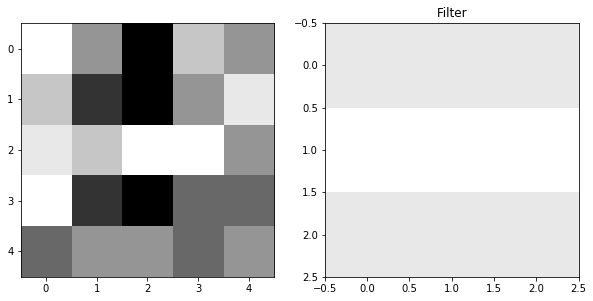

In [4]:
im = np.array([[0,3,6,2,3],
               [2,5,6,3,1],
               [1,2,0,0,3],
               [0,5,6,4,4],
               [4,3,3,4,3]])

# show the image we'll convolve, and the filter we'll convolve it with
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(im, cmap="Greys"), plt.title("Starting Image")
ax2.imshow(a, cmap="Greys",vmin=0,vmax=6), plt.title("Filter")

conved_im = np.zeros((3,3)) # we'll replace these as we get the new values

The first step is to take the 3x3 block in the upper left of our image, and multiply that by our weights:

Text(0.55, 0.6, 'new image so far')

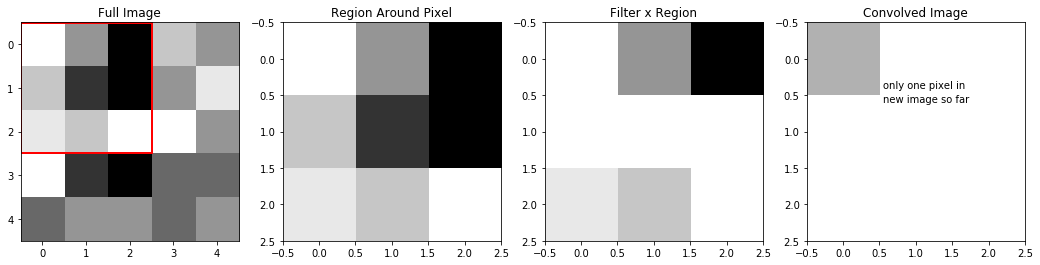

In [5]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)
ax1.imshow(im, cmap = "Greys"), ax1.set_title("Full Image")
ax1.add_patch(matplotlib.patches.Rectangle((-.48,-.48),2.98,2.98,fill=False,color='red',lw=2)) #show region to convolve

ax2.imshow(im[0:3,0:3],cmap="Greys"), ax2.set_title("Region Around Pixel")
ax3.imshow(im[0:3,0:3]*a,cmap="Greys",vmin=0,vmax=6), ax3.set_title("Filter x Region")

conved_im[0][0] = np.sum(im[0:3,0:3]*a)
ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29), ax4.set_title("Convolved Image") #here, I prematurely set vmax to what the maximum of conved_im
plt.annotate("only one pixel in", (.55,.4))                                         #will be, otherwise scaling will change as it plots
plt.annotate("new image so far", (.55,.6))

We can see, that because our filter was a row of ones, a row of zeros, then another row of ones, when we apply this filter to our region, the middle row becomes zeros, while the top and bottom rows of the region are unchanged. So, the sum of Filter X Region which creates our new pixel is really just the sum of the top and bottom rows of the region. 

Next, let's move over one pixel, and do the same thing:

Text(0.95, 0.7, 'now, 2 pixels')

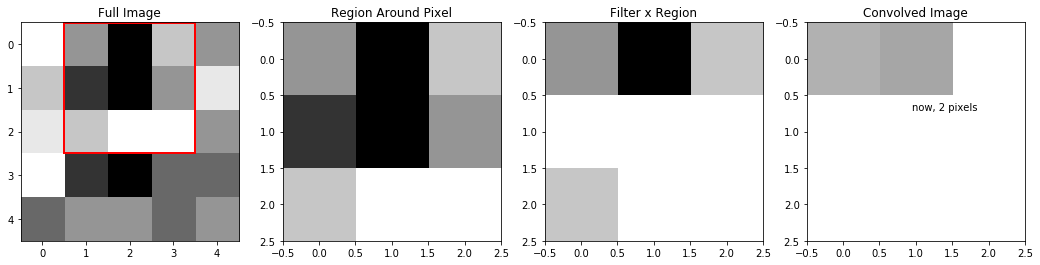

In [6]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)
ax1.imshow(im, cmap = "Greys"), ax1.set_title("Full Image")
ax1.add_patch(matplotlib.patches.Rectangle((.5,-.48),3,2.98,fill=False,color='red',lw=2)) #show region to convolve

ax2.imshow(im[0:3,1:4],cmap="Greys", vmin=0, vmax=6), ax2.set_title("Region Around Pixel")
ax3.imshow(im[0:3,1:4]*a,cmap="Greys",vmin=0,vmax=6), ax3.set_title("Filter x Region")

conved_im[0][1] = np.sum(im[0:3,1:4]*a)
ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29), ax4.set_title("Convolved Image") #here, I prematurely set vmax to what the maximum of conved_im
plt.annotate("now, 2 pixels", (.95,.7))                                             #will be, otherwise scaling will change as it plots

We can keep moving it over, and filling in the pixels of this "new version" of our image:

In [7]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)

display_ims = []
conved_im = np.zeros((3,3)) # reset this
for i in range(conved_im.shape[0]):
  for j in range(conved_im.shape[1]):
    im1 = ax1.imshow(im, cmap = "Greys",animated=True)
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),3,3,fill=False,color='red',lw=2)) #show region to convolve

    im2 = ax2.imshow(im[i:i+3,j:j+3],cmap="Greys", vmin=0, vmax=6, animated=True)
    ax2.set_title("Region Around Pixel")
    im3 = ax3.imshow(im[i:i+3,j:j+3]*a,cmap="Greys",vmin=0,vmax=6, animated=True)
    ax3.set_title("Filter x Region")

    conved_im[i][j] = np.sum(im[i:i+3,j:j+3]*a)
    im4 = ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29, animated=True) #here, I prematurely set vmax to what the maximum of conved_im
    ax4.set_title("Convolved Image")                                       #will be, otherwise scaling will change as it plots

    display_ims.append([im1, im2, im3, im4])

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

<a id='1.3'></a>
**<font size="4"> 1.3 Padding**</font>

You'll notice that this convolution reduced our image size: while we started with a 5x5 image, our convolved version was only 3x3. This is because we're only able to fit a 3x3 filter onto a 5x5 image, 3x3 times. We aren't able to make "new" pixels out of the ones on the border of the image - our filter can't fit.
For this reason, we usually **pad** images before we convolve them - or add values all around the border of the image. Padding ensures two important things:


1.   <font size="2.5">That the image isn't downsized by a convolution
2.   <font size="2.5">That pixels on the outer edges "count" as much as pixels in the middle. That is - that they're convolved over as many times as pixels closer to the center of the image.

There are many different choices for padding, each with their own unique advantages, but the most common/universal (and the only one we'll discuss here) is **valid**, **zero** padding. **Valid** means that we add whatever padding we need in order to keep the image the same size. **Zero** just means that the values we add along the borders are all zeros.


If we valid zero-pad the image we were just using, we would get:

(<matplotlib.image.AxesImage at 0x7fc3797b1b38>,
 Text(0.5, 1.0, 'Padded Image'))

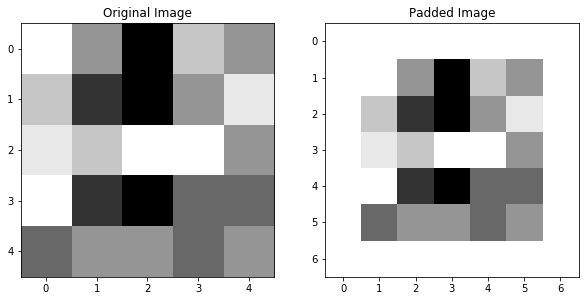

In [8]:
padded_im = np.pad(im, pad_width = (1,1), mode="constant", constant_values=0)

# show the image we'll convolve, and the filter we'll convolve it with
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(im, cmap="Greys"), ax1.set_title("Original Image")
ax2.imshow(padded_im, cmap="Greys",vmin=0,vmax=6), ax2.set_title("Padded Image")

We can see, if we re-do the convolution we did to this image in the last section, now with the padded image, that pixels on the edge of the image are also convolved over, and the image size is preserved:

In [9]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)

display_ims = []
conved_im = np.zeros((5,5)) # now, we'll have 5x5 pixels to fill in
for i in range(conved_im.shape[0]):
  for j in range(conved_im.shape[1]):
    im1 = ax1.imshow(padded_im, cmap = "Greys",animated=True)
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),3,3,fill=False,color='red',lw=2)) #show region to convolve

    im2 = ax2.imshow(padded_im[i:i+3,j:j+3],cmap="Greys", vmin=0, vmax=6, animated=True)
    ax2.set_title("Region Around Pixel")
    im3 = ax3.imshow(padded_im[i:i+3,j:j+3]*a,cmap="Greys",vmin=0,vmax=6, animated=True)
    ax3.set_title("Filter x Region")

    conved_im[i][j] = np.sum(padded_im[i:i+3,j:j+3]*a)
    im4 = ax4.imshow(conved_im,cmap="Greys",vmin=0,vmax=29, animated=True) #here, I prematurely set vmax to what the maximum of conved_im
    ax4.set_title("Convolved Image")                                       #will be, otherwise scaling will change as it plots

    display_ims.append([im1, im2, im3, im4])

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

We can see that the 3x3 region that we convolved before remains the same in both images, but when we pad the image, we also get information about the edge pixels that before we weren't going over.

Valid padding means padding in order to maintain image size. In our example above, this means we just had to add a border of single-pixel width to our image. In general though, the size of the border you need to add will depend on a few parameters. The parameters that determine the size after you perform a convolution are:


*   **n**: the size of the input image (assumed square, so it's nxn)
*   **f**: the size of the filter (assumed square, so it's fxf)
*   **s**: the **stride**, or how much you move the filter over before you do the next convolution. In our above examples, we've always used s=1, but in general, s can be any number that will still make the filter fit evenly inside the image. We will assume that you use the same stride along all of the image dimensions.
*   **p**: the width of the padding to be added, assumed the same amount will be added all around the image.

Then, the output dimension of the image will be:

\begin{equation*}
n_{out} \times n_{out} = \frac{n - f + 2p}{s} + 1
\end{equation*}

So, depending on the image size, filter size, and stride selected, you can determine the width of the padding that will need to be added to keep $n_{out} = n$.


<a id="1.4"></a>
**<font size="4"> 1.4 Adding Bias and Activations**</font>

Before we go on, we need to talk about two other fundamental steps that happen after we convolve an image, which are the final building blocks of what happens in a convolutional layer of neural network. First, we need to talk about bias parameters, then, we'll talk about the activtion step.

We've already talked about how we can intepret each step of a convolution as replacing a pixel with a linear combination of it and the pixels around it. But a classic linear combination has the format:

\begin{equation*}
y = m_1x_1 + m_2x_2 + m_3x_3 + ... + b
\end{equation*}

And so far, we haven't added b. We refer to this extra parameter as the **bias**, it's a single value that get's added to every pixel of the image after the image has been convolved. You need a bias for sort of the same reason that you need b when you fit a line: because it can act to shift the entire image one way, in a way that otherwise can be impossible given just the values $\times$ weights.

Beacuse the bias is just a single number added to every pixel, it's a very simple augmentation of the image:

(<matplotlib.image.AxesImage at 0x7fc3794cd208>,
 Text(0.5, 1.0, 'Convolved Image + (b = -10)'))

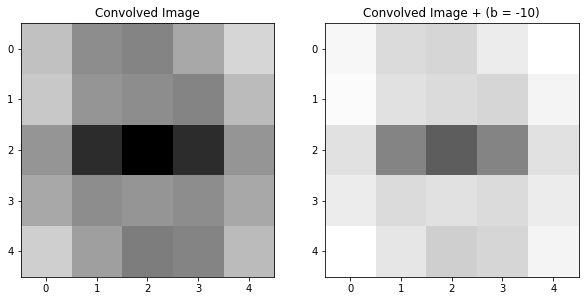

In [10]:
bias = -10
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
ax1.imshow(conved_im, cmap="Greys", vmin=-5, vmax=29), ax1.set_title("Convolved Image")
biased_im = conved_im + bias
ax2.imshow(biased_im, cmap="Greys", vmin=-5, vmax=29), ax2.set_title("Convolved Image + (b = %d)" %bias)


In the above example, we can see that adding the bias dimmed the entire image.

The other step that happens after the convolution step in a convolutional layer is the activation. In the activation step, the image is subject to a function, so each pixel of the image is changed according to that function. In convolutional neural networks, the most common of these functions is ReLU (Rectified Linear Units), which looks like:
\begin{equation*}
ReLU(x) = max(0,x)
\end{equation*}
So, when an image is passed through the ReLU activation, each pixel becomes either 0 (if the value was negative) or remains the same (if the value was 0 or positive).
An image passed through this activation will look like:



(<matplotlib.image.AxesImage at 0x7fc37937b588>,
 Text(0.5, 1.0, 'Relu-ed Image'))

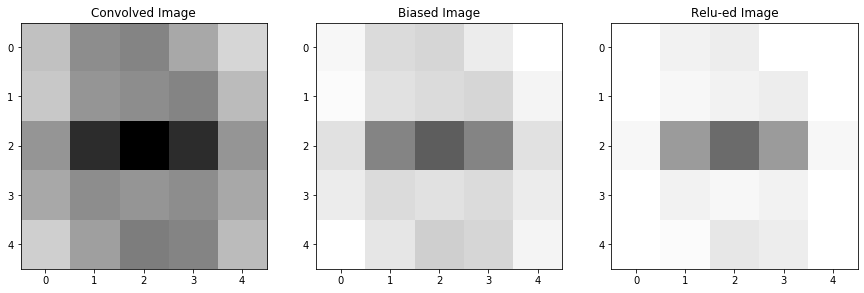

In [11]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.add_subplot(1,3,1), fig.add_subplot(1,3,2), fig.add_subplot(1,3,3)
ax1.imshow(conved_im, cmap="Greys", vmin=-5, vmax=29), ax1.set_title("Convolved Image")
ax2.imshow(biased_im, cmap="Greys", vmin=-5, vmax=29), ax2.set_title("Biased Image")
relu_im = np.maximum(0,biased_im)
ax3.imshow(relu_im, cmap="Greys", vmin=0, vmax=29), ax3.set_title("Relu-ed Image")

When we added the bias to our image, some of our pixels became negative. That means that, after we applied the activation function, these pixels actually became zero-valued, meaning our final image now has some areas of whitespace that weren't there before.

It may seem as though this activation function merely removes information: pixels that previously had value are now becoming zeroed-out, now lending us no information about the image. We won't go into a detailed explanation as to why activation functions are so important (as well as an explanation of the advantages and disadvantages of different choices for the activation function), but there are many resources online that do a deep-dive into this topic. For now, I'll just give the main reasons why we include the activation step:


*   Dying gradients
*   prevent weights from blowing up



<a id="2"></a>
<font size="5">**2. Interpreting Filters**</font>

The point, really, of a UNet, is to learn the weights of the filters, and the biases, that transform an image and allow us to augment that image into another image. So, we may want to attempt to look at the filters and determine the ways that it might be transforming our image and helping to learn patterns. 

<a id="2.1"></a>
**<font size="4"> 2.1 The Horizontal Edge Detector**</font>


Some filters, such as the **horizontal edge detector** are fairly easily intepretable in the ways that they tranform an image. We'll take a look at the horizontal edge detector below.

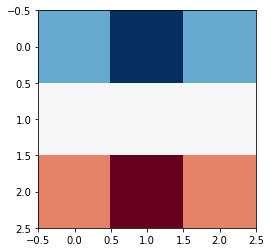

In [12]:
horiz_edge_filter = np.array([[ 1,  2,  1],
                              [ 0,  0,  0],
                              [-1, -2, -1]])

plt.imshow(horiz_edge_filter, cmap = 'RdBu')

This filter is comprised of: a row of positive values, a row of zero values, and a row of negative values.
It may not be immediately obvious how this can pick out horizontal edges, but consider the case of an image with a very simple horizontal edge:

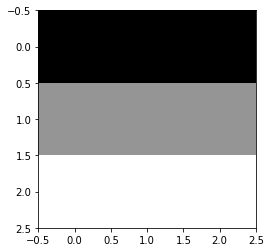

In [13]:
horiz_edge_im = np.array([[ 1, 1, 1],
                          [ 0, 0, 0],
                          [ -1, -1, -1]])

plt.imshow(horiz_edge_im, cmap = 'Greys')

If we convolve this image with this filter (that is, take the sum of the element-wise products of these two 3x3 matricies) we will get a single number:

In [14]:
conved_val = np.sum(horiz_edge_filter*horiz_edge_im)
print("The new pixel value would be:", conved_val)

The new pixel value would be: 8


If instead, this image had been of a vertical edge. Then, when we check what value the convolution gives us, we intead get:


The new pixel value would be: 0


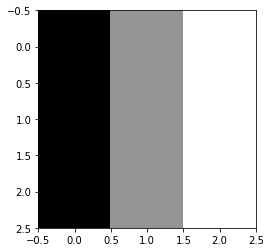

In [15]:
vert_edge_im = np.array([[ 1, 0, -1],
                         [ 1, 0, -1],
                         [ 1, 0, -1]])

plt.imshow(vert_edge_im, cmap = 'Greys')

conved_val = np.sum(horiz_edge_filter*vert_edge_im)
print("The new pixel value would be:", conved_val)

We can see that the structure of the filter is that it's symmetric along its horizontal axis. That is, the row of positive values is mirrored by a row of negative values at the bottom of the filter. This means that, any portion of an image which it is applied to, which is also symmetric along its horizontal axis, will give us a value of 0, because the positive and negatives will cancel out.

\begin{equation*}
\begin{bmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{bmatrix} \times \begin{bmatrix}a&b&c\\a&b&c\\a&b&c\end{bmatrix} = a + 2b + c + 0 -a -2b -c = 0
\end{equation*}

Whereas a portion of an image that changes values along its horizontal axis will give us a nonzero value.

Note that, the values in the center row of the image never matter, because the center row of the filter is all zeros.

<a id="2.2"></a>
**<font size="4"> 2.2 The Horizontal Edge Detector in Action**</font>

You may notice that an image like the one below, which you would identify as a horizontal line, will not get identified by this filter, because 

*   It's horizontally symmetric, and
*   Every element-wise multiplication includes a zero.

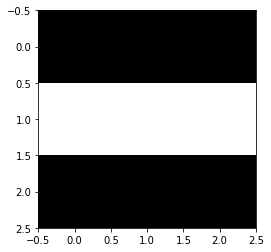

In [16]:
horiz_edge_im = np.array([[ 1, 1, 1],
                          [ 0, 0, 0],
                          [ 1, 1, 1]])

plt.imshow(horiz_edge_im, cmap = 'Greys')

But, in practice, we apply these filters over a larger image, not over an image of matching size, so we'll see that single-pixel edges are still detected by this filter, *just not when the edge is on the center pixel.*

Let's start by loading in an image with some edges, which we'll pass our horizontal edge detector over.


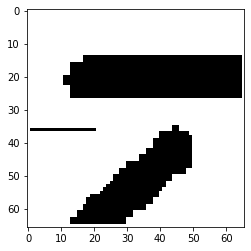

In [17]:
from PIL import Image
im = np.array(Image.open('filepath/images/horiz_im.png'))[:,:,2]
im = im/255
im = np.round(im)

im[35][0:20] = 1 #add a single-pixel-width edge, to see if we can detect that too
padded_im = np.pad(im, pad_width = (1,1), mode="constant", constant_values=0)


plt.imshow(padded_im, cmap="Greys")

Now, if we convolve with our filter like we did in Part 1:

<font size="2">**note, this code may take a little time to run*

In [18]:
fig = plt.figure()

# first, get the filter sizes which will help us later
filter_sz = horiz_edge_filter.shape[0]
filter_width = int(np.floor(filter_sz/2))

conv_ims = []
conved_im = padded_im.copy() # set it to a copy, that way we can watch the image transform
for i in range(1, im.shape[0]+1): # from 1-65 instead of 0-64, because we added the padding
  for j in range(1,im.shape[0]+1):
    # first, replace the pixel in the image with the convolved one
    conved_region = padded_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1]*horiz_edge_filter
    conved_im[i,j] = np.sum(conved_region) # replace pixels of the copy with the convolution
    # make an image where the filter is overlayed, too
    filter_im = conved_im.copy()
    filter_im[i-filter_width:i+filter_width+1,j-filter_width:j+filter_width+1] = conved_region
    if (i>12 and i<18 and j>10) or (i>50 and i<55 and j>10) or (i>33 and i<37 and j<20): # it would take too long to plot the whole movie, so just do interesting parts
      conv_ims.append([plt.imshow(filter_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)]) # with filter overlayed
      conv_ims.append([plt.imshow(conved_im, animated=True, cmap = 'RdBu_r',vmin=-2,vmax=2)]) # convolved im result

ani = animation.ArtistAnimation(fig, conv_ims, interval=100, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

There are a few important things to note about this output image:


1.   <font size="2.5">That the output image contains both <font color=blue>blue</font> and <font color=red>red</font> pixels - this filter is able to pick out not only the edge, but the *direction* the edge is going in - that is, higher valued to lower valued pixels or vice versa.
2.   <font size="2.5">That the single-pixel width edge *is* detected by this filter - and is replaced with these two representations of the edge - where the edge created a border of low to high valued pixels, and where it creates a border of high to low valued pixels.
3.   <font size="2.5">The perfectly vertical portions of the thick lines are ignored by the filter - but diagonal regions are still detected.


In A U-Net, we want to learn the filters that can transform our image. To do this, we usually must convolve an image with many different filters, with deeper layers applying filters to versions of the image which have already been convolved. So as you can probably guess, the filters of a real U-Net are usually not doing something as simple and interpretable as the horizontal edge detection.

In Section 4, we'll talk more about how to view and interpret the filters of a UNet trained on a real-world example, but for now, we'll take a break to establish exactly what the UNet is doing.

<a id="3"></a>
<font size="5">**3. The Architecture of a UNet**</font>

Now that we have some foundations about the convolutions that a UNet uses to learn how to transform an image, we'll take a closer look at architecture of a UNet which makes this possible.

<a id="3.1"></a>
**<font size="4"> 3.1 The UNet Structure**

The basic structure of a UNet looks like this:


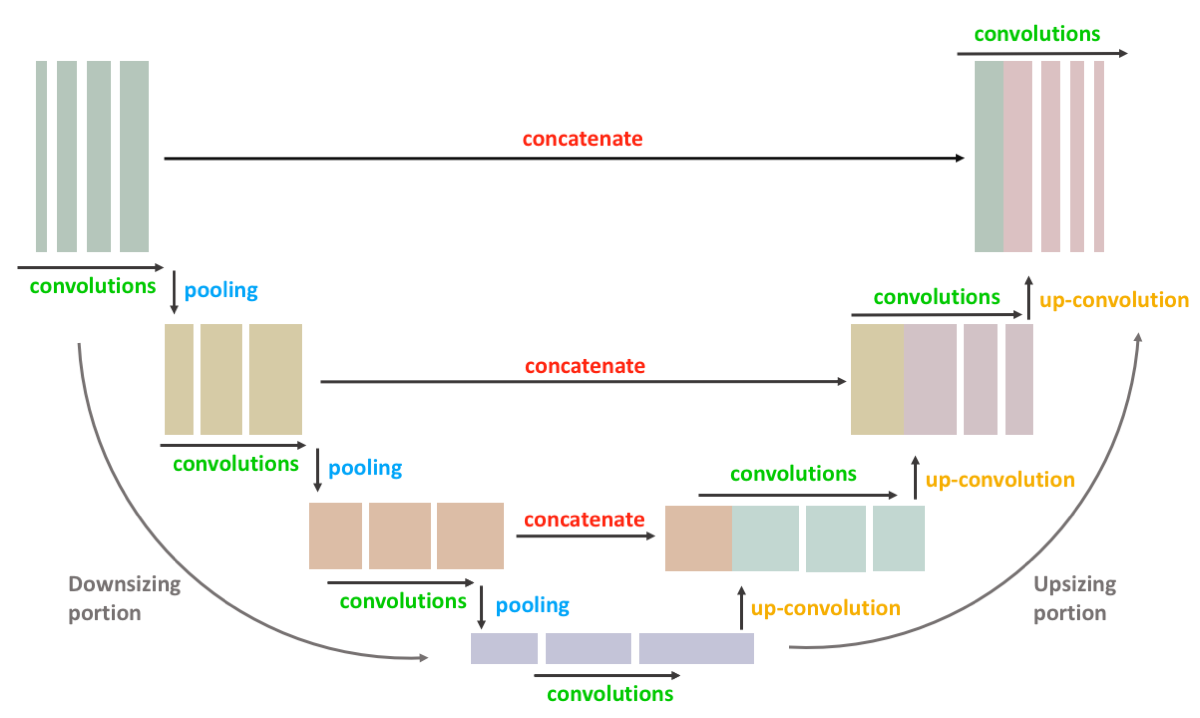

In [19]:
display(Im('%s/images/UNet_Structure.png' %filepath, width=650, height=400))

U-Nets are named as such because they have this U-like shape, where the input image is first reduced in dimensionality in the downsizing portion, then increased in dimensionality back to its original size in the upsizing portion. As you can see, there are 4 main types of operations, which we'll briefly describe here but give a detailed description of in the upcoming subsections:

1.   <font size="3"><font color=#2CC214>**convolutions**</font>: We have already discussed the convolution operation and components of a convolutional layer. In these convolutional portions, the image is convolved repeatedly, with differing (and often differently sized) filters.
2.   <font size="3"><font color=#09DAFF>**pooling**</font>: The image is decreased in dimensionality, by representing regions of a few pixels of the image with only one pixel.
3.   <font size="3"><font color=#FBB300>**up-convolutions**</font>: Sort of the opposite of pooling, one pixel is copied several times to become multiple pixels of the image, in order to increase the image dimensionality.
4.   <font size="3"><font color=red>**concatenations**</font>: An image from a previous part of the network is stacked with the image from the current part of the network

<a id="3.2"></a>
**<font size="4"> 3.2 Convolutions and Convolution Blocks**</font>

We already talked about convolutions in Section 1. Here, we'll take a look at exactly what makes a convolutional layer, and how those layers stack to extract the information we want from our image.

You can use a filter to convolve an image. But usually in a convolutional network, we want to use many filters to convolve an image, because each filter is learning something different about the image. Additionally, we usually perform multiple convolutions in a row of the same number of filters/shape of filter, in what's often called a **convolutional block**. Here, we might convolve our image with 5 3x3 filters, then take the result of that convolution, and convolve it with another 5 3x3 filters.

So what exactly is the output of a convolution, and what do we do when we have 5 of them?

If we start with an image, say 8x8, and we convolve it with a 3x3 filter, then provided that we valid padded it first, we get out a 8x8 image which is some version of the original:

(<matplotlib.image.AxesImage at 0x7fc37706fb70>,
 Text(0.5, 1.0, 'Convolved Image'))

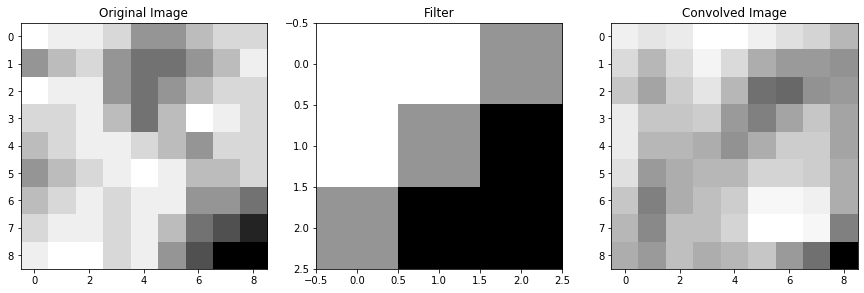

In [20]:
im = np.array([[0,1,1,2,4,4,3,2,2],  # the region of pixels
               [4,3,2,4,5,5,4,3,1],
               [0,1,1,4,5,4,3,2,2],
               [2,2,1,3,5,3,0,1,2],
               [3,2,1,1,2,3,4,2,2],
               [4,3,2,1,0,1,3,3,2],
               [3,2,1,2,1,1,4,4,5],
               [2,1,1,2,1,3,5,6,7],
               [1,0,0,2,1,4,6,8,8]])

filt1 = np.array([[-1,-1,0], # a filter I made up
                  [-1,0,1],
                  [0,1,1]])

from scipy.ndimage import convolve    # a handy function that can do convolutions for us
conv_im1 = convolve(im, filt1, mode = 'constant')  # set mode=constant for valid padding

fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
ax1.imshow(im, cmap='Greys'), ax1.set_title('Original Image')
ax2.imshow(filt1, cmap='Greys'), ax2.set_title('Filter')
ax3.imshow(conv_im1, cmap='Greys'), ax3.set_title('Convolved Image')

If we have a second filter, then we have another version of the image which was convolved with that filter:

(<matplotlib.image.AxesImage at 0x7fc376f7ab70>,
 Text(0.5, 1.0, 'Convolved Image #2'))

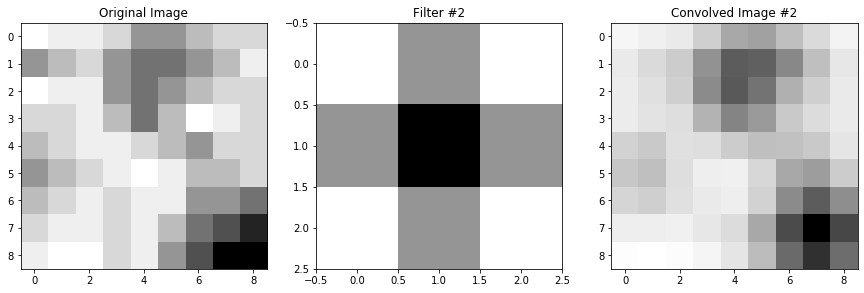

In [21]:
filt2 = np.array([[1,2,1],  # another filter I made up
                  [2,3,2],
                  [1,2,1]])

conv_im2 = convolve(im, filt2, mode = 'constant')  # set mode=constant for valid padding

fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
ax1.imshow(im, cmap='Greys'), ax1.set_title('Original Image')
ax2.imshow(filt2, cmap='Greys'), ax2.set_title('Filter #2')
ax3.imshow(conv_im2, cmap='Greys'), ax3.set_title('Convolved Image #2')

If we have 5 such filters, then we have 5 unique "versions" of the original image:

(<matplotlib.image.AxesImage at 0x7fc376df9be0>,
 Text(0.5, 1.0, 'Convolved Image #5'))

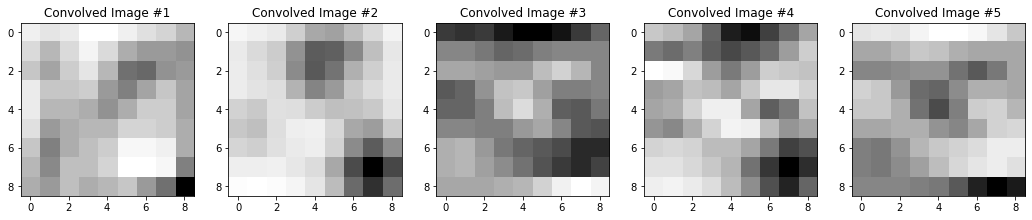

In [22]:
filt3 = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])    # more filter that I made up, not necessarily
filt4 = np.array([[0,1,0], [2,3,2], [-1,-2,-1]])    # ones that should do anything interesting
filt5 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])

conv_im3 = convolve(im, filt3, mode = 'constant')
conv_im4 = convolve(im, filt4, mode = 'constant')
conv_im5 = convolve(im, filt5, mode = 'constant')

fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1,5)
ax1.imshow(conv_im1, cmap='Greys'), ax1.set_title('Convolved Image #1')
ax2.imshow(conv_im2, cmap='Greys'), ax2.set_title('Convolved Image #2')
ax3.imshow(conv_im3, cmap='Greys'), ax3.set_title('Convolved Image #3')
ax4.imshow(conv_im4, cmap='Greys'), ax4.set_title('Convolved Image #4')
ax5.imshow(conv_im5, cmap='Greys'), ax5.set_title('Convolved Image #5')

Now, we have 5 representations of our original image, each with some unique features that were emphasized or de-emphasized because of the filter that created them. 
So, we want a way to keep all of this information that our filters gave us. But, we also want a way to be able to associate these versions of the image with one another. The dark pixels in the bottom right of all of these convolved images above, for example, are all some representation of the dark region in the lower right of our starting image. That is, the bottom right regions of our convolved images still correspond to and give us information about the bottom right region of our original image.

So, what we do is *stack* the images so that each one becomes a **channel** of one complete image. These channels are just like the RGB channels you might be used to in normal color images: each one contains some information about the image, and each matching pixel across different channels is telling you something about the same region of the image. That's exactly what our convolved images are doing - they're each telling us different pieces of information about the same regions of the original image.

When we stack these convolved images into channels, we increase the depth of the image: our **8x8x(1 channel)** original image is now an **8x8x(5 channel)** image.

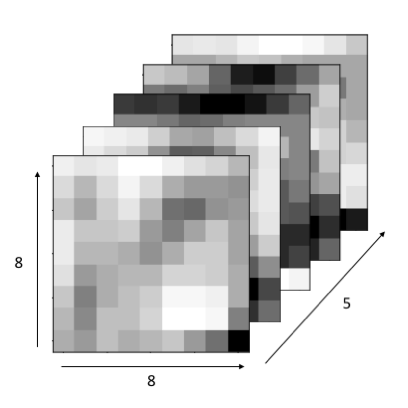

In [17]:
display(Im('%s/images/operation_examples/conv_example_im1.png' %filepath, height=370, width=370))

Next, it's typical to convolve our image a second time. Let's say that our convolution block involves a second set of convolutions, where this time we want to use **3, 3x3 filters**.

You might be wondering: how are we going to convolve an 8x8**x5** image with a 3x3 filter? The answer is that our filters will now also need to have 5 channels, so really, we'll be using 3, 3x3**x5(channel)** filters.

<font size="2">**Note:** I keep making this distinction that these third dimensions are *channels*. That's because it's an important distinction: convolutions can happen in 3D, too, so a 3x3x5 filter (not a 3x3x(5 channel)) filter actually would, in general, be a somewhat different operation, which I'll point out and talk about more in a little bit. This is why we would still refer to the second set of filters in this convolution block as 3x3 filters, instead of specifying that they have 5 channels. The number of channels is implied by the network architecture; if we were to call them 3x3x5 filters it would sound like we are doing 3D convolutions.

When we convolve a multi-channel image with a multi-channel filter (always with the matching number of channels as the image), what we are effectively doing is convolving each channel of our image with its own filter, and then adding the results togeher. So, in the second part of our convolution block, where we have 3, 3x3x(5 channel) filters, it's really like each filter gives us 5 versions of our image.

Let's look at what **one** of the filters is doing:

(<matplotlib.image.AxesImage at 0x7fc376a6a240>,
 (-0.5, 8.5, 8.5, -0.5),
 Text(0.5, 1.0, 'Convolved Image Channel #5'))

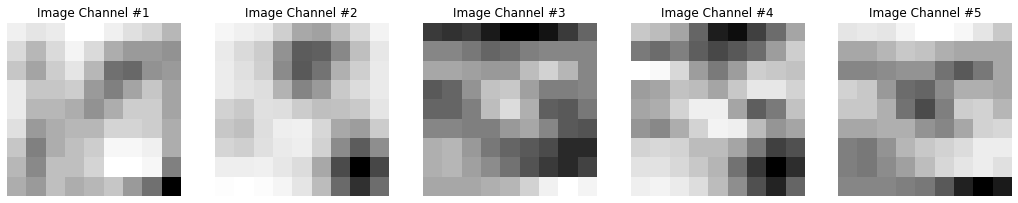

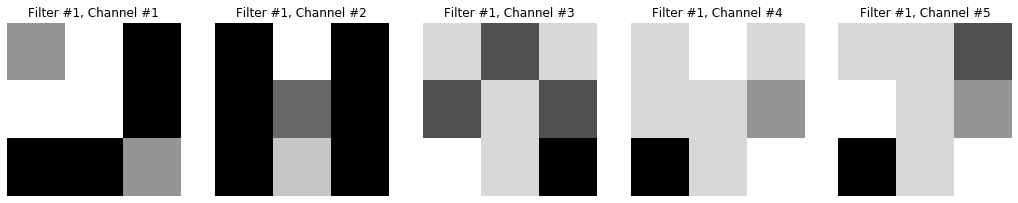

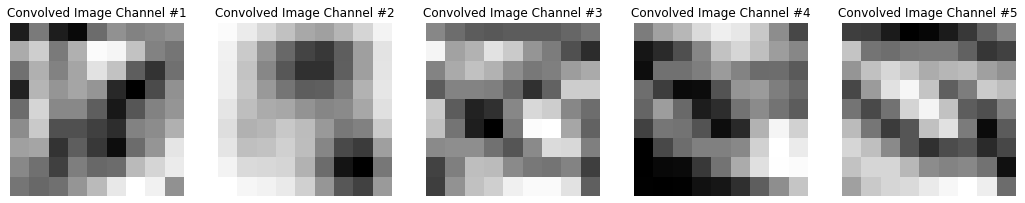

In [24]:
fig = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1,5)
ax1.imshow(conv_im1, cmap='Greys'), ax1.set_title('Image Channel #1'), ax1.axis('off')
ax2.imshow(conv_im2, cmap='Greys'), ax2.set_title('Image Channel #2'), ax2.axis('off')
ax3.imshow(conv_im3, cmap='Greys'), ax3.set_title('Image Channel #3'), ax3.axis('off')
ax4.imshow(conv_im4, cmap='Greys'), ax4.set_title('Image Channel #4'), ax4.axis('off')
ax5.imshow(conv_im5, cmap='Greys'), ax5.set_title('Image Channel #5'), ax5.axis('off')

fig2 = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4, ax5 = fig2.subplots(1,5)
# Filter #1, 5 channels, each 3x3
filt1_ch1 = np.array([[0,-1,1],[-1,-1,1],[1,1,0]])
ax1.imshow(filt1_ch1, cmap='Greys'), ax1.axis('off'), ax1.set_title('Filter #1, Channel #1')
filt1_ch2 = np.array([[2,-1,2],[2,1,2],[2,0,2]])
ax2.imshow(filt1_ch2, cmap='Greys'), ax2.axis('off'), ax2.set_title('Filter #1, Channel #2')
filt1_ch3 = np.array([[-1,1,-1],[1,-1,1],[-2,-1,2]])
ax3.imshow(filt1_ch3, cmap='Greys'), ax3.axis('off'), ax3.set_title('Filter #1, Channel #3')
filt1_ch4 = np.array([[-1,-2,-1],[-1,-1,0],[2,-1,-2]])
ax4.imshow(filt1_ch4, cmap='Greys'), ax4.axis('off'), ax4.set_title('Filter #1, Channel #4')
filt1_ch5 = np.array([[-1,-1,1],[-2,-1,0],[2,-1,-2]])
ax5.imshow(filt1_ch5, cmap='Greys'), ax5.axis('off'), ax5.set_title('Filter #1, Channel #5')

fig3 = plt.figure(figsize=(18,5))
ax1, ax2, ax3, ax4, ax5 = fig3.subplots(1,5)
# Convolve each channel of the 8x8x5 image with the corresponding filter channel
filt1_ch1_convIm = convolve(conv_im1, filt1_ch1, mode = 'constant')
ax1.imshow(filt1_ch1_convIm, cmap='Greys'), ax1.axis('off'), ax1.set_title('Convolved Image Channel #1')
filt1_ch2_convIm = convolve(conv_im2, filt1_ch2, mode = 'constant')
ax2.imshow(filt1_ch2_convIm, cmap='Greys'), ax2.axis('off'), ax2.set_title('Convolved Image Channel #2')
filt1_ch3_convIm = convolve(conv_im3, filt1_ch3, mode = 'constant')
ax3.imshow(filt1_ch3_convIm, cmap='Greys'), ax3.axis('off'), ax3.set_title('Convolved Image Channel #3')
filt1_ch4_convIm = convolve(conv_im4, filt1_ch4, mode = 'constant')
ax4.imshow(filt1_ch4_convIm, cmap='Greys'), ax4.axis('off'), ax4.set_title('Convolved Image Channel #4')
filt1_ch5_convIm = convolve(conv_im5, filt1_ch5, mode = 'constant')
ax5.imshow(filt1_ch5_convIm, cmap='Greys'), ax5.axis('off'), ax5.set_title('Convolved Image Channel #5')

So, we start with a 5-channel image, we convolve each channel with the corresponding filter of a 5-channel filter, and we get out 5 images.

If we have 3 of such filters, that would give us 3 (filters) x 5(channels) = 15 versions of our image. You might expect that we would stack all of these again, and end up with a 8x8x15 output from this convolution, *but that's not the case*.

Although we **stack** the outputs of our filters into channels, we actually **add** the channels of an image after it's convolved. So really, the output of our first convolution, using Filter #1, a 3x3x(5 channel) filter on our 8x8x(5 channel) image is:

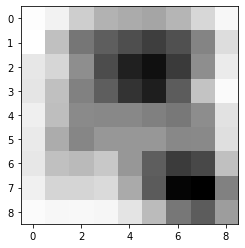

In [25]:
filt1_convOutput = filt1_ch1_convIm + filt1_ch2_convIm + filt1_ch3_convIm + filt1_ch4_convIm + filt1_ch5_convIm

plt.imshow(filt1_convOutput, cmap="Greys")

So, actually, if the second set of convolutions in our convolutional block had 3, 3x3 filters, the output of the layer would be an 8x8x(3 channel) image. That is, **the number of channels in the output of a convolutional layer is equal to the number of filters used**. Regardless of the number of channels the input to the convolutional layer had, because we add the channels together after applying our filters, we always end up with **one image per filter**.

Okay, now you might be wondering: *why* do we add these multiple channels together, but we stacked the outputs from different filters instead of adding those together. Why don't we do the same thing in both cases? The logic is roughly this: think of the purpose of each filter to be to learn something different about our image. Adding together the outputs from different filters would muddle their information together, so we want to make sure to keep the information preserved by stacking. But multi-channel filters, while they sort of act like multiple filters over multiple images, are truly *one* filter over *one* image. So, if we want those filters to focus on learning one thing about the image, then we want to add the channels together: because the multiple channels should be *working together* to tell us something about the image.

So, in summary:


*   **Convolutional blocks** are typically made up of a few convolutional layers.
*   A **covolutional layer** typically involves convolving the image input to the layer with many filters, all of the same size.
*   The output of a convolutional layer is an image with multiple **channels** - one per filter.
*   If the input to a convolutional layer has multiple channels, the filters used on the image in that layer must all have the same number of channels as the image.
*   Each channel of the input image is convolved with a corresponding channel of the filter, to create a corresponding channel of the output.
*   The *channels* of an output image convolved with one filter are **added** together to make one image per filter, but the images generated by different filters are **stacked** to create the multiple channels of the output.



<a id="3.2.1"></a>
**<font size="4"> 3.2.1 *Some follow up on that note about 3D convolutions***</font>

3D convolutions are convolutions over volumes. A 3x3x3 filter over a volume performs a similar operation as a 3x3 filter over a 2D image, in that the weights of the filter are multipled by a region of the image, then summed together to get one pixel value. The only real difference, is that a 3D filter on a 3D volume also strides over the volume dimension, instead of just across the image in the 2D dimensions.

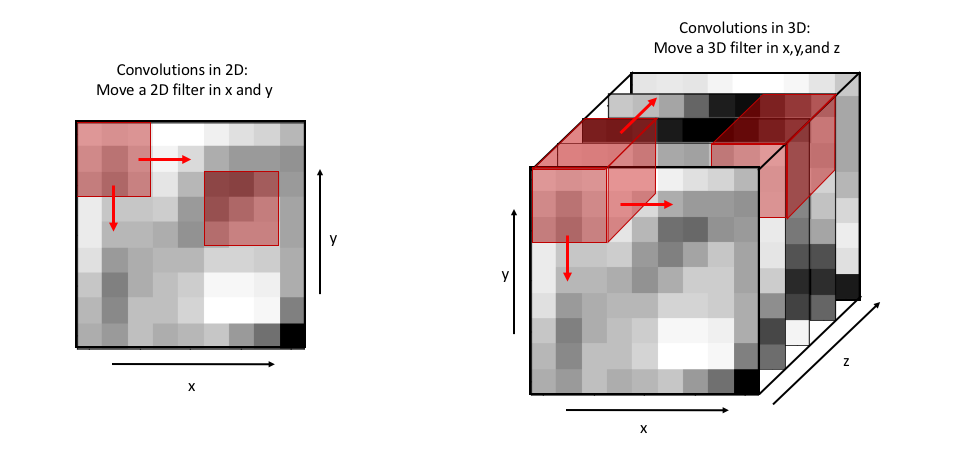

In [18]:
display(Im('%s/images/operation_examples/3D_vs_2D_convs.png' %filepath, height=400, width=850))

Thus, a 3D convolution over a volume will usually also produce a volume: the original image will usually be padded in all dimensions, so that as the filter slides over all dimensions of the image, multiplying the weights and adding them together, the output volume has the same dimensions as an input volume.


In principle, our 3x3x(5 channel) filters are acting the same on an 8x8x(5 channel) image as a 3x3x5 3D filter would act on an 8x8x5 3D volume, in that we are mutiplying the weights by the pixel values and adding the results together to get one pixel value.




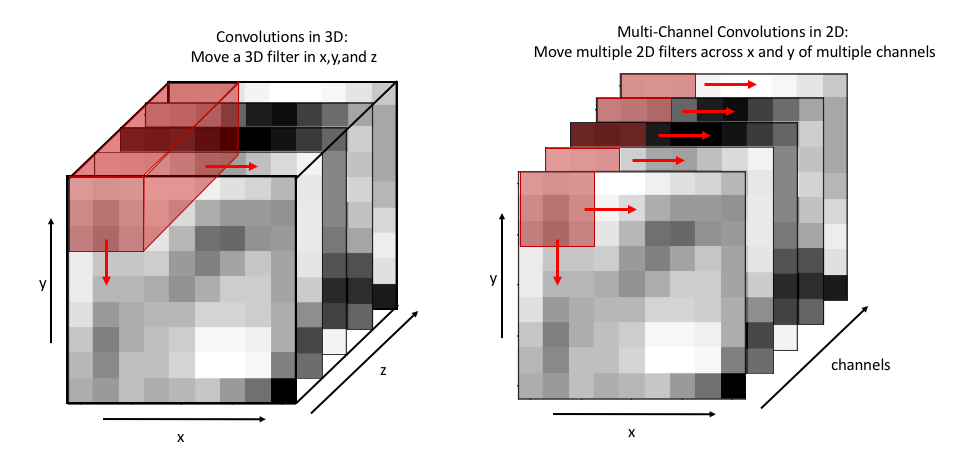

In [19]:
display(Im('%s/images/operation_examples/3D_vs_2DMultiChannel_convs.png' %filepath, height=400, width=850))

But, that doesn't mean that multi-channel convolutions and 3D convolutions are generally the same thing. This only happens because, if the dimension of a filter matches the dimension of an image, the filter can't slide over in that dimension. In the example above, the 3x3x5 3D filter can't slide in the z dimension, so it can only move along x and y just like our multi-channel filter would. But 3D filters will typically be symmetric the way that 2D filters are typically symmetric: a 3D filter would likely be size 3x3x3, instead of 3x3x5, just like a 2D filter is almost always something like 3x3 instead of 3x5. Thus, a 3D convolution will usually be able to slide back along the z dimension of an image, and output a volume.

This is an important distinction because 3D volumes can *also* have multiple channels - in which case there would be multiple 3D filters making up one multi-channel 3D filter, and then thinking about multi-channel convolutions as just 3D convolutions doesn't work anymore.

<a id="3.3"></a>
**<font size="4"> 3.3 Pooling**</font>

The basic idea behind pooling is to reduce the dimensionality of an image, by representing some region of pixels with just one pixel instead.

**Max pooling** is the most common type of pooling, and the type that we will use in our examples in this tutorial. In max pooling, a region of pixels is represented by the maximum-valued pixel within that region.
So, we would represent a region of pixels like this one:

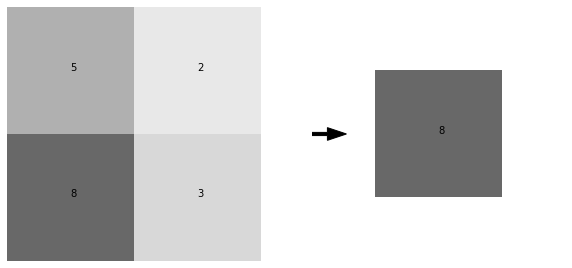

In [28]:
im = np.array([[5,2],  # the region of pixels
               [8,3]])
im_max = np.max(im)    # what pooling would give us

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)
ax1.axis('off'), ax2.axis('off')

# plot the image region with values 
ax1.imshow(im, cmap="Greys", vmin=0, vmax=12)
for j in range(im.shape[0]):
  for i in range(im.shape[1]):
    ax1.annotate(im[i][j], (j,i))

# plot the resulting region
ax2.imshow(np.pad(np.array([im_max]*4).reshape(2,2),pad_width = (1,1), mode="constant", constant_values=0), # just makes it look nice
           cmap="Greys", vmin=0, vmax=12)
ax2.annotate(im_max, (1.5,1.5))
ax2.arrow(-1.25,1.5,1,0,width=.05,head_width=.2,color='k') #draw an arrow


This would be **2x2** max pooling, because the region of pixels that we replace with a single pixel is size 2x2. We can arbitrarily choose the region size that we use for pooling, but this region is almost always square, and 2x2 is a very typical choice.

2x2 max pooling an entire image involves taking every 2x2 region in the image and replacing it like so:

In [29]:
im = np.array([[0,3,6,2,1,2],
               [2,5,6,3,1,1],
               [1,2,0,0,3,1],
               [2,5,6,4,4,4],
               [2,3,3,4,3,0],
               [0,2,4,5,1,0]])

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)
ax1.axis('off'),ax2.axis('off')

display_ims = []
pooled_im = np.zeros((3,3))        # output image will have output shape = original shape / 2 for 2x2 pooling
for ind1 in range(pooled_im.shape[0]):
  i = ind1*2         # so that we have an index that moves over by 2 pixels each time, instead of 1
  for ind2 in range(pooled_im.shape[1]):
    j = ind2*2
    im1 = ax1.imshow(im, cmap="Greys", vmin=-1, vmax=10, animated=True)
    for k in range(im.shape[0]):
      for l in range(im.shape[1]):
        im1 = ax1.annotate(im[k][l], (l,k))    # plot the pixel values
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.48+j,-.48+i),2,2,fill=False,color='red',lw=2)) #show region of pooling

    pooled_im[ind1][ind2] = np.max(im[i:i+2,j:j+2])
    im2 = ax2.imshow(pooled_im,cmap="Greys",vmin=-1,vmax=10, animated=True)
    ax2.set_title("Pooled Image")                                       

    display_ims.append([im1, im2, ax2.annotate(int(pooled_im[ind1][ind2]), (ind2,ind1))]) #also show pixel values

ani = animation.ArtistAnimation(fig, display_ims, interval=1000, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

We won't discuss any of them in detail here, but there are other types of pooling. **Average pooling**, for instance, takes the average pixel value of a region as the new pixel value.

You might be wondering: what's the advantage of throwing away information?
1.   <font size="2.5"> Computationally, it's advantageous to remove some information, especially if we can still retain the "most important" information when we do so. In convolutional neural networks in particular, the number of operations we need to perform scales with the size of the image as we convolve it, so reducing the image size can greatly reduce the number of computations we need to do.
2.   <font size="2.5"> Pooling may help to "sharpen" certain features in the image. Because filters are sort of trying to pick out specific features in an image, choosing the pixel that gave the highest "signal" in a region of an image may help to single out the most important parts of that image.

<a id="3.4"></a>
**<font size="4"> 3.4 Upsampling**</font>

Upsampling is unique to UNets - the step is performed because we need to increase the size of our image after a series of convolutions and pooling has decreased it. In this way, it's like the opposite of pooling - instead of shrinking an image by representing a region of pixels with one pixel, we create a region of pixels by copying one pixel into multiple pixels.

In [30]:
im = np.array([[1,3,6],
               [2,5,6],
               [2,4,3]])

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)

display_ims = []
upsampled_im = np.zeros((6,6))        # output image will have output shape = original shape * 2 for 2x2 upsampling
for i in range(pooled_im.shape[0]):
  ind1 = i*2
  for j in range(pooled_im.shape[1]):
    ind2 = j*2
    im1 = ax1.imshow(im, cmap="Greys", vmin=-1, vmax=10, animated=True)
    for k in range(im.shape[0]):
      for l in range(im.shape[1]):
        im1 = ax1.annotate(im[k][l], (l,k))    # plot the pixel values
    ax1.set_title("Full Image")
    im1 = ax1.add_patch(matplotlib.patches.Rectangle((-.5+j,-.5+i),1,1,fill=False,color='red',lw=2)) #show we're upsampling

    for k in range(ind1,ind1+2):
      for l in range(ind2,ind2+2):
        upsampled_im[k][l] = im[i,j]
        im2 = ax2.imshow(upsampled_im,cmap="Greys",vmin=-1,vmax=10, animated=True)
        display_ims.append([im1,im2,ax2.text(l,k,int(upsampled_im[k][l]))]) # plot the pixel values too
    ax2.set_title("Upsampled Image")                                       

ani = animation.ArtistAnimation(fig, display_ims, interval=600, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_html5_video())

So, you can see that even though the upsampled image looks identical to the original, it actually has dimensions 6x6 instead of 3x3, and 4 times the number of pixels.

<a id="3.5"></a>
**<font size="4"> 3.5 Concatenations**</font>

Concatenations are also unique to UNets. As we convolve our image and pool it, we lose the spatial information of our features. If we've reduced the dimensionality of our starting image to 2x2, for example, then each pixel in that 2x2 image represents about a quarter of our initial image, meaning that we've lost all information about finer resolution features within each quarter.

If we were to simple upsample and convolve our image back up to its original size, there would be no way to get that information back, because upsampling just copies the same pixels over again - it doesn't increase the resolution of the details. For this reason, we need to do **concatenations**.

In the concatenation step, we take the output of a previous layer in the downsizing portion of the UNet, and stack it with the output from the upsizing portion of the UNet that has the same dimensions. In this way, we get to use the finer resolution information that the downsizing steps still had, but we also get our larger scale information from our upsampling step.

For instance, let's say in the second convolutonal block of a UNet, we convolve our image with 3 filters, so we have an output that looks like this:

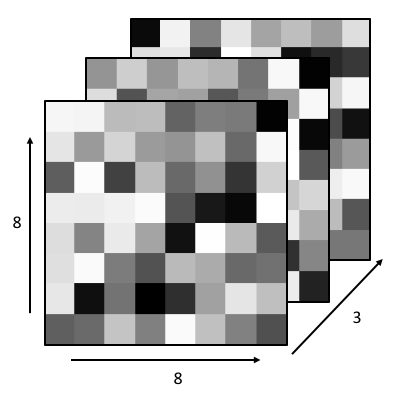

In [11]:
display(Im('%s/images/operation_examples/concat_example_im1.png' %filepath, height=370, width=370))

Then, let's say that in the next steps in the UNet, this image is pooled down to size 4x4x3, and more convolutions are done on the image, keeping it at size 4x4x3 but further transforming it.

If after these convolutions, we begin the upsizing portion of the UNet, we would begin with an operation which upsamples the 4x4x3 image back into an 8x8x3 image, which looks like:

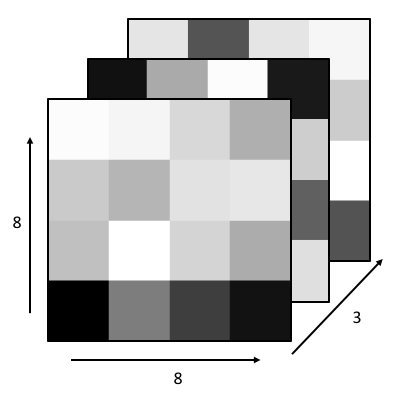

In [12]:
display(Im('%s/images/operation_examples/concat_example_im2.png' %filepath, height=370, width=370))

In the concatenation step of the UNet, these two 8x8x3 images are stacked, so the image becomes 8x8x6. Then, this stacked image would go on to be convolved further, with the 6 stacked images all acting as different channels of the same image.

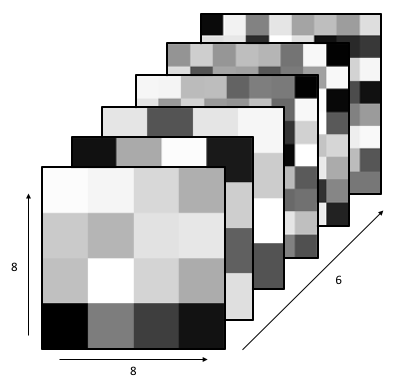

In [16]:
display(Im('%s/images/operation_examples/concat_example_im3.png' %filepath, height=400, width=400))

<a id="5"></a>
<font size="5">**4. A Very Simple UNet Example**</font>

To get a better handle on how exactly these operations work, how they transform our image, and how they change the dimensionality of the image at each step, let's closely investigate an extremely simple example of a UNet.

<a id="4.1"></a>
**<font size="4"> 4.1 The Data/Problem**</font>

Say we have a simple 8x8 image, made of black and white pixels randomly scattered. And we want to create a UNet to invert the image for us. Our data might look like this:

Text(0.5, 1.0, 'out')

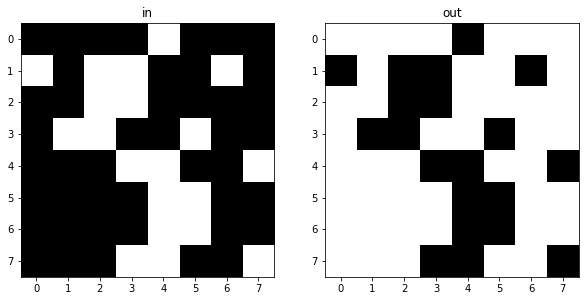

In [34]:
im_in = np.array([[0,0,0,0,1,0,0,0],   # example image in, which we'll also use for testing later
              [1,0,1,1,0,0,1,0],       # obviously, not a real random scattering, but just an example
              [0,0,1,1,0,0,0,0],
              [0,1,1,0,0,1,0,0],
              [0,0,0,1,1,0,0,1],
              [0,0,0,0,1,1,0,0],
              [0,0,0,0,1,1,0,0],
              [0,0,0,1,1,0,0,1]])

im_out = np.abs(1-im_in)              # example image output, just the inversion of the input image

# show our example images
fig=plt.figure(figsize=(10,5))
ax1,ax2 = fig.subplots(1,2)
ax1.imshow(im_in, cmap="Greys_r")
ax1.set_title("in")
ax2.imshow(im_out, cmap="Greys_r")
ax2.set_title("out")


And we can easily generate a dataset of 100 examples:

In [0]:
X_example = []
y_example = []
for i in range(100):
  X_example.append(np.round(np.random.rand(8,8)).reshape(8,8,1))
  y_example.append(np.abs(1-X_example[-1]).reshape(8,8,1))

X_example = np.array(X_example)
y_example = np.array(y_example)

This inversion operation is obviously very simple: It takes one line of code and 2 operations (a subtraction and an absolute value) to perfectly invert our image. But, because this is a transformation of an image, a very simple UNet should also be able to perform this inversion for us, so that's what we'll try to make here.

<a id="4.2"></a>
<font size="4"> **4.2 The Architecture**</font>

We'll use a simple UNet, with a few 3x3 filters, to do this inversion. The architecture will look like this:

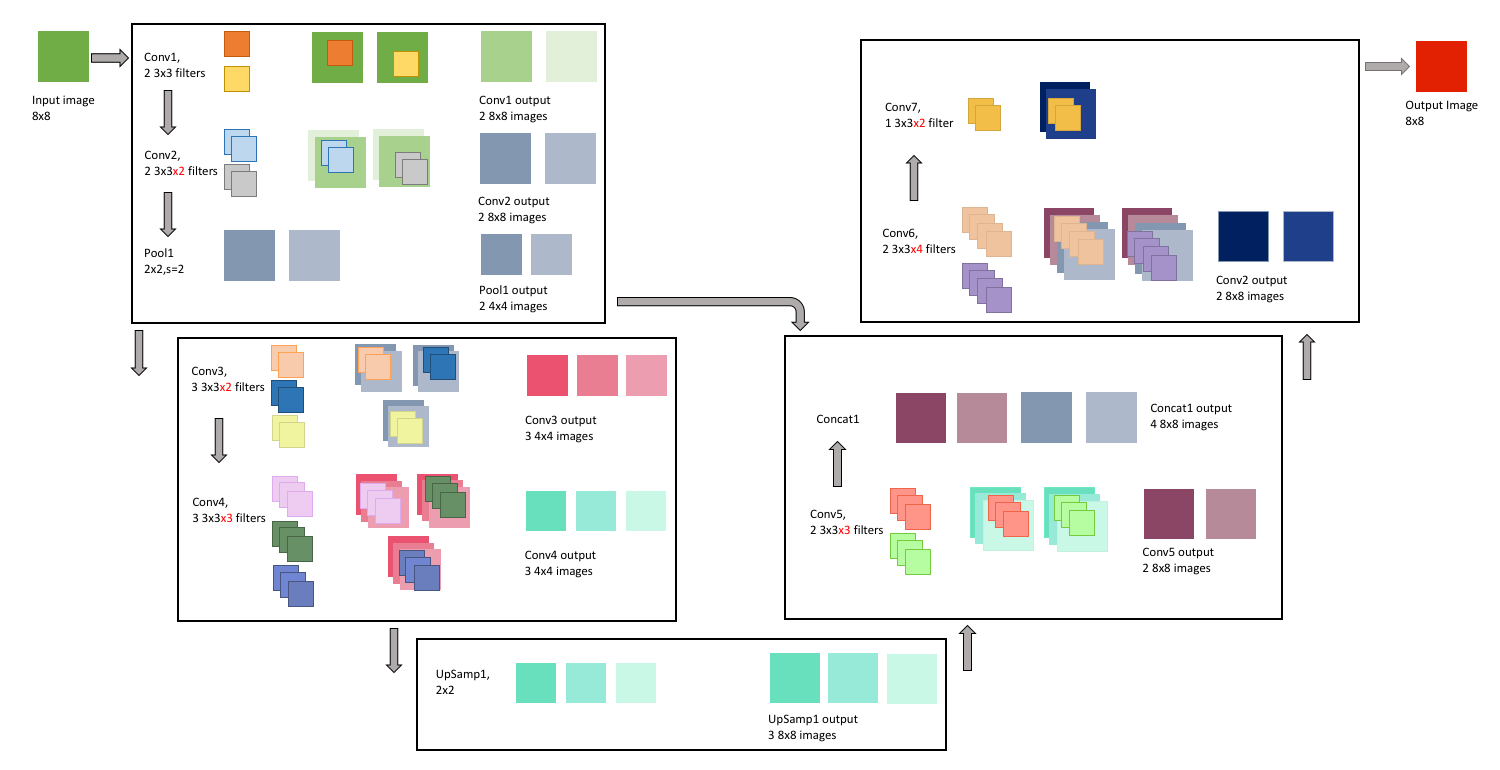

In [36]:
display(Im('%s/images/simple_example_UFormat.png' %filepath, width=950, height=480))

This might look a little overwhelming right now, but we're going to go through each of the operations that this network will perform in more detail in the upcoming sections.

We will also add layers to the model in keras as we go through them. To start building a model in keras, we just need to start defining our layers. This begins with the input:

In [37]:
input_size = X_example[0].shape    # get the size of the input images, in our case this is 8x8x1
print(input_size) 

inputs = Input(input_size)         # then, we just define an input layer and tell keras to expect images of size 8x8x1

(8, 8, 1)




<a id="4.3"></a>
**<font size="4"> 4.3 Conv Block #1**</font>

The first convolution block has 3 steps:

1.   <font size="2.5"> Conv1: 2 3x3 filter convolutions
2.   <font size="2.5"> Conv2: 2 3x3 filter convolutions
3.   <font size="2.5"> Pool1: 2x2 pooling



In the first convolution step, the input image is convolved twice: Once with <font color=#e67300>**one 3x3 filter**</font>, and another time with <font color=#ffd633>**another 3x3 filter**</font>. We first pad the input image with zeros, so that the convolved image is 9x9, and the result is **2, 8x8 images**, that we then add our bias to and then pass through the ReLu activation function. Each of these images is a "representation" of the original image. These images are stacked to become two channels of the same image, and the layer output is **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3 weights, and an associated bias for each filter, this means our first layer has a total of:
\begin{equation*}
2\times(3\times3) + 2 = 20
\end{equation*}
learnable parameters.

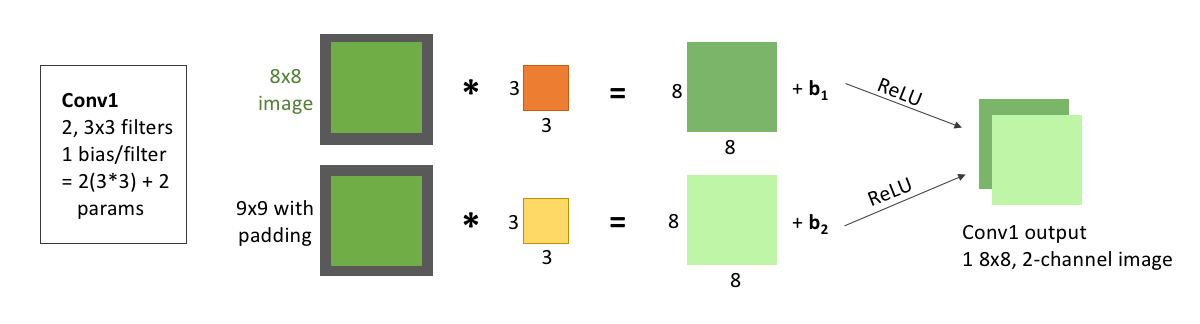

In [38]:
display(Im('%s/images/layers/conv1.png' %filepath, height=270, width=1000))

We can add this to the model:

In [39]:
conv1 = Conv2D(filters = 2,   # here, we tell the layer we want to use 2 filters
               kernel_size = (3,3),  # the filters are of size 3x3
               activation = 'relu',    # we want to use the ReLU activation function
               padding = 'same',     # same padding means the output size will equal the input size(before padding)
               kernel_initializer = 'he_normal')(inputs)  # we'll initialize the weights with the He normal distribution. We also
                                                          # need to tell this layer what the input to it will be, which is the input
                                                          # layer (inputs)

The next convolution step, takes the output from the first convolution step, and again convolves it twice: Once with <font color=#79a6d2>**one 3x3x2 filter**</font>, and another time with <font color=#a6a6a6>**another 3x3x2 filter**</font>. Note that these filters now need to have 2 channels, because the output from the first layer had 2 channels. As we discussed in the previous section, when a 2-channel filter convolves a 2-channel image, the outputs are added together to generate the output. That is, the <font color= #3973ac>**darker blue**</font> filter convolves the <font color=#8cd98c>**lighter green**</font> channel of the image, and the <font color=#8cb3d9>**lighter blue**</font> filter convolves the <font color=#4b9b5f>**darker green**</font> image. Then, the two channel outputs are added together to create the <font color=#9875a3>**darker purple**</font> image generated from the convolution. The same, of course, happens with the grey filter and the image, generating the <font color=#d9b3e6>**lighter purple**</font>, the second of our two output images.

As with the first convolution layer, we pad the input image with zeros, add a bias after the convolution, and pass the images through the ReLu activation function. These output images are again stacked to become two channels of the same image, making the layer output **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3x2 weights, and an associated bias for each filter, this means this second layer has a total of:
\begin{equation*}
2\times(3\times3\times2) + 2 = 38
\end{equation*}
learnable parameters.

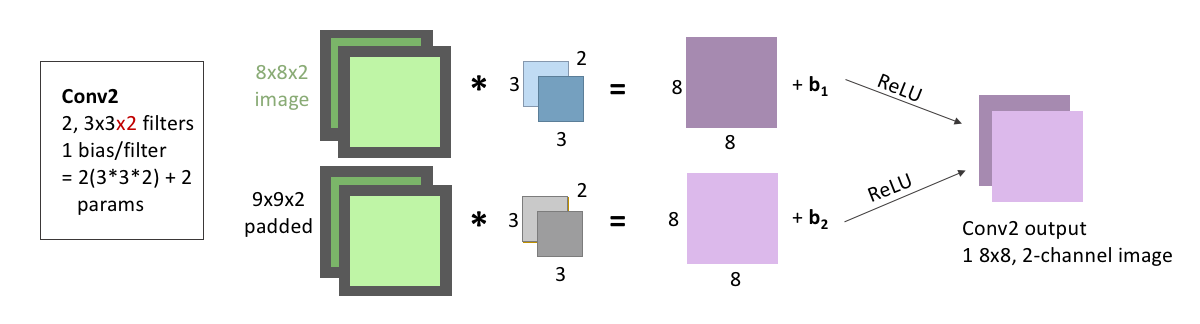

In [40]:
display(Im('%s/images/layers/conv2.png' %filepath, height=270, width=1000))

We add this to our model, the same way we added the first convolution:

In [0]:
conv2 = Conv2D(filters = 2,   # 2 filters again
               kernel_size = (3,3),  # size 3x3 filters. Keras is smart, so we don't need to tell it that these filters need to have 2
                                     # channels; it will know that because it will know that the input to the layer has 2 channels
               activation = 'relu', padding = 'same',    # we'll be keeping the activation, padding, and initializer the same for all
               kernel_initializer = 'he_normal')(conv1)  # of our layers. But note, the input to this layer was now the output from
                                                         # conv1

The last step in this convolution block is pooling, where we downsize our image by applying 2x2 pooling to it.

There are no learnable parameters in a pooling step, but it's important to note that we *do not* pool across channels - our **8x8x2** output becomes **4x4x2**, because the two channels are each pooled seperately and remain stacked.

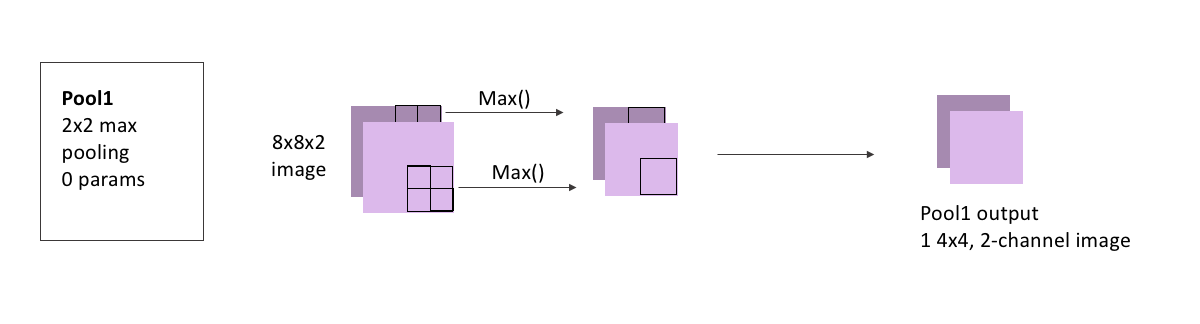

In [42]:
display(Im('%s/images/layers/pool1.png' %filepath, height=270, width=1000))

Adding a pooling layer to our model is also straightforward with Keras:

In [43]:
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)   # we just need to tell it the size of the region to pool,
                                                # and that we're pooling the output from conv2

<a id="4.4"></a>
**<font size="4"> 4.4 Conv Block #2**

The second convolution block mimics the first, but we'll increase the number of filters:

1.   <font size="2.5"> Conv3 has 3 3x3 filter convolutions
2.   <font size="2.5"> Conv4 has 3 3x3 filter convolutions

We also won't pool here, as the image is already small enough, and the next step will be to re-increase the image size.



For Conv3, the input image is convolved three times: with 3 filters that each have size 3x3, and 2 channels because our output from the pooling layer had 2 channels. As always, we first pad the input image with zeros, add our bias after the convolution, and pass through the ReLu activation function. These images are stacked to become three channels of the same image, and the layer output is **1, 4x4x3(channel) image**.

Because we have 3 filters, each with 3x3x2 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
3\times(3\times3\times2) + 3 = 57
\end{equation*}
learnable parameters.

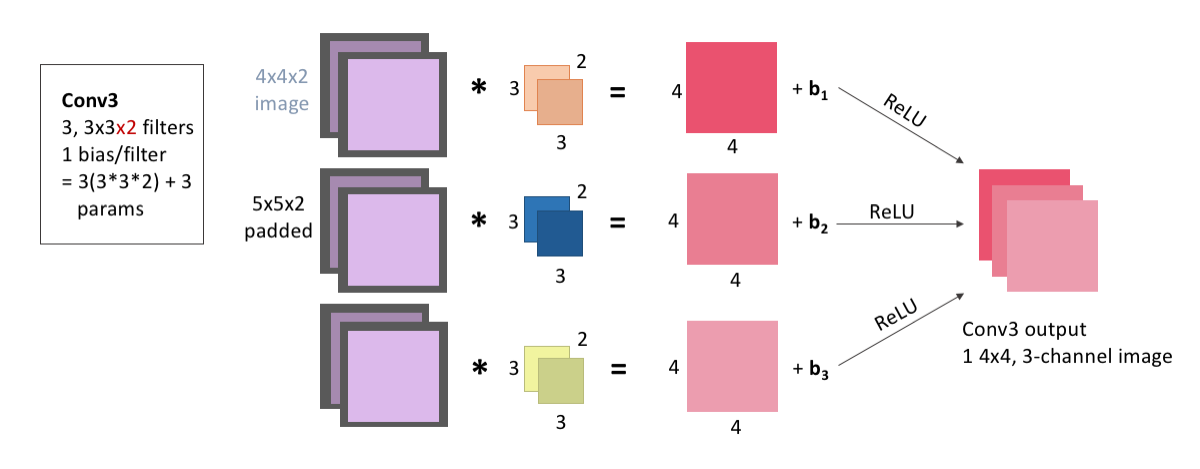

In [44]:
display(Im('%s/images/layers/conv3.png' %filepath, height=370, width=1000))

Adding this to our model:

In [0]:
conv3 = Conv2D(filters = 3, kernel_size = (3,3),  #again, we don't need to tell it that we'll need 2-channel filters
               activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

For Conv4, the input image is convolved three times: with 3 filters that each have size 3x3, and 3 channels because our output from the Conv3 layer had 3 channels (because it was convolved with 3 filters). We pad the input image with zeros, add our bias after the convolution, and pass through the ReLu activation function. These images are stacked to become three channels of the same image, and the layer output is **1, 4x4x3(channel) image**.

Because we have 3 filters, each with 3x3x3 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
3\times(3\times3\times3) + 3 = 84
\end{equation*}
learnable parameters.

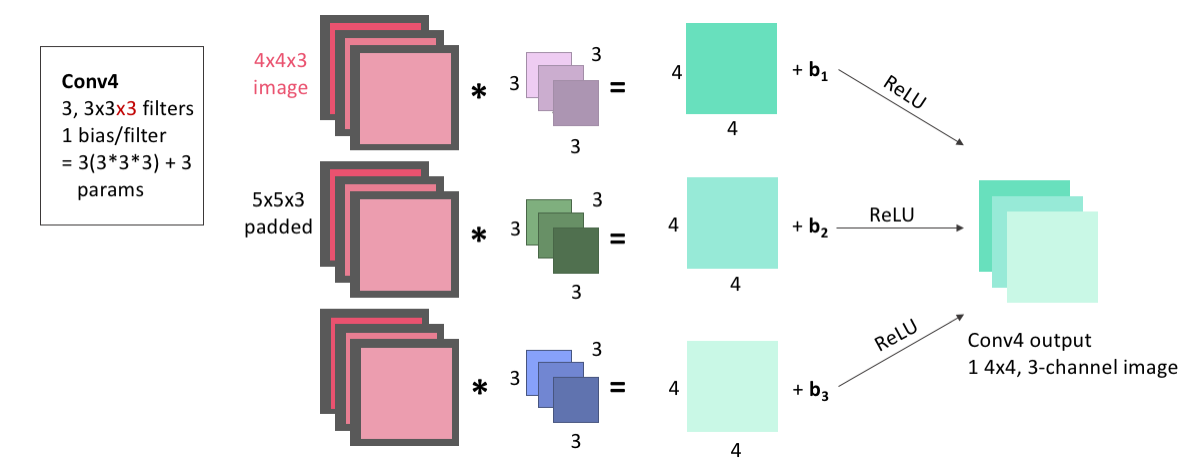

In [46]:
display(Im('%s/images/layers/conv4.png' %filepath, height=370, width=1000))

Again, this is easy to add to the model:

In [0]:
conv4 = Conv2D(filters = 3, kernel_size = 3,  # if you just give kernel_size a single number, it assumes a square filter of that dimension
               activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

<a id="4.5"></a>
**<font size="4"> 4.5 UpConv Block #1**</font>

Next, we begin the upsizing portion of the UNet. This first Up-Convolution block will have 3 steps:

1.   <font size="2.5"> UpSamp1 will do 2x2 upsampling
2.   <font size="2.5"> Conv5 has 2 3x3 filter convolutions
3.   <font size="2.5"> Concat1 will stack Conv5 output with Conv2 output

In the upsampling step, we'll upsize our image taking each pixel and copying it into a 2x2 square.

There are no learnable parameters in an upsampling step, but it's important to note that, as with pooling, channels aren't upsampled - our **4x4x3** image becomes **8x8x3**, because the two channels are each upsampled seperately and remain stacked.

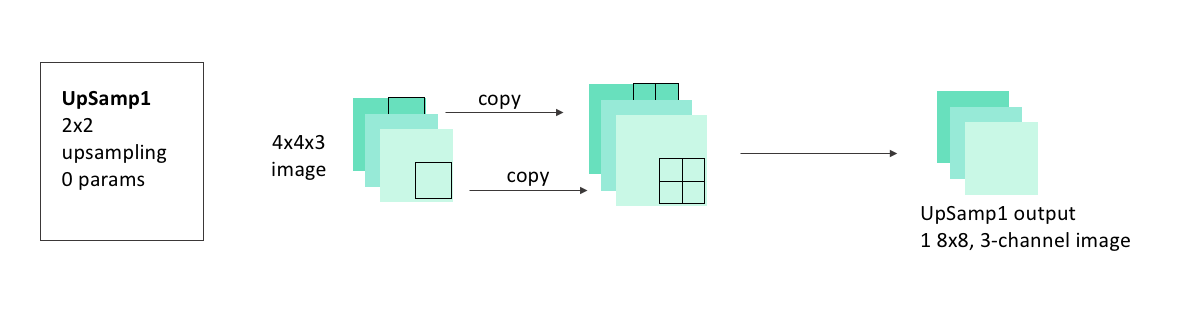

In [48]:
display(Im('%s/images/layers/upsamp1.png' %filepath, height=270, width=1000))

Adding the upsampling layer to our model is also as easy as adding the pooling layer was:

In [49]:
up1 = UpSampling2D(size = (2,2))(conv4)

In the Conv5 step, the image we just created by upsampling is convolved two times: with 2 filters that each have size 3x3, and 3 channels. As always, we pad the input image with zeros before the convolution, and add one bias for each filter before passing the image through the ReLu activation function. These images are stacked to become two channels of the same image, and the layer output is **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3x3 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
2\times(3\times3\times3) + 2 = 56
\end{equation*}
learnable parameters.

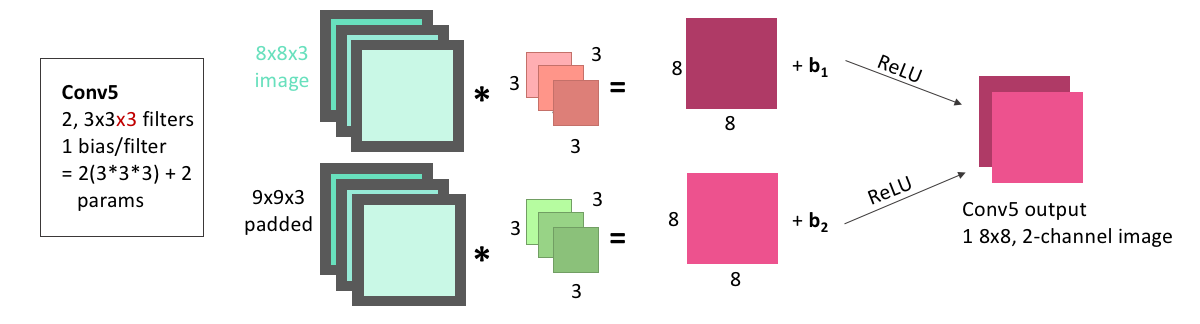

In [50]:
display(Im('%s/images/layers/conv5.png' %filepath, height=270, width=1000))

We can add this convolutional layer to the mode making sure that we are applying it to the output from the upsampling layer:

In [0]:
conv5 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up1)

Next is the concatenation step. We now have an 8x8x(2 channel) image as the output from Conv5. We also had, from our downsizing steps, an 8x8x(2 channel) image as the output from Conv2. In the concatenation step, we stack these together so that we have an 8x8x(4 channel) image.

Concatenations, because they just involve stacking images,  will have no learnable parameters.

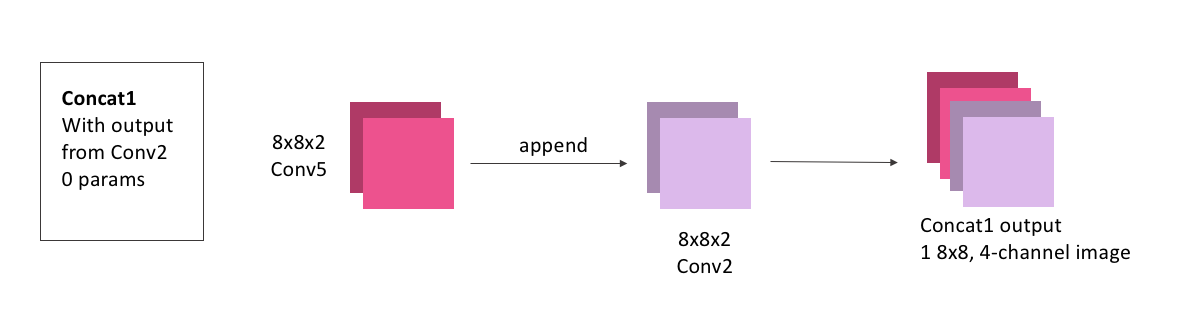

In [52]:
display(Im('%s/images/layers/concat1.png' %filepath, height=270, width=1000))

To do this concatenation with keras, we just need to specify what layer outputs (conv5 and conv2) we're looking to concatenate:

In [0]:
concat1 = concatenate([conv2,conv5], axis = 3)     # axis = 3 tells the model that we need to stack these images as extra channels. Both
                                                   # conv5 and conv3 will have shape (None, 8, 8, 2), so axis = 3 means to stack along the axis
                                                   # which has shape 2, the channel axis

<a id='#4.6'></a>
**<font size="4"> 4.6 UpConv Block #2**</font>

This is the final block in our model. It will contain

1.   <font size="2.5"> Conv6: 2, 3x3 convolutions
2.   <font size="2.5"> Conv7: 1 3x3 convolution

Conv6 will convolve our concatenated image, with 2 filters that each have size 3x3, and 4 channels. We will pad, add bias, and ReLU as usual. The layer output is **1, 8x8x2(channel) image**.

Because we have 2 filters, each with 3x3x4 weights, and an associated bias for each filter, this means this layer has a total of:
\begin{equation*}
2\times(3\times3\times4) + 2 = 74
\end{equation*}
learnable parameters.

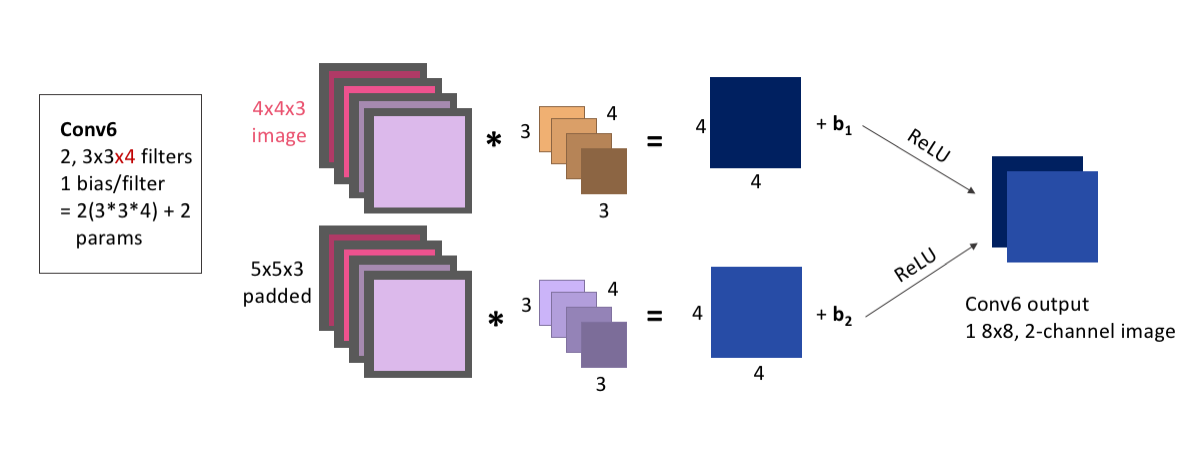

In [54]:
display(Im('%s/images/layers/conv6.png' %filepath, height=370, width=1000))

We add this to the model the same as any other convolutional layer, making sure we apply it to the output from our concatenation:

In [0]:
conv6 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat1)

Finally, Conv7 will convolve our image, with 1 filter of size 3x3, and 2 channels. Because our input only had 1 channel, our final convolution must use only 1 filter, to ensure that the output has only 1 channel. We will pad and add bias as usual. 

The one difference from all of our other convolutional layers that we'll make is using the **sigmoid** activation function rather than ReLU. Because of the shape of the sigmoid function, values are more easily forced to be either 0 or 1. Because this is our output layer, and we know that our data was comprised of exclusively 0 or 1-valued pixels, the signmoid function will hopefully help to squash our pixel values to the correct one of these two values.

The layer output is **1, 8x8 image**. Because we have 1 filter with 3x3x2 weights, and an associated bias, this layer has a total of:
\begin{equation*}
1\times(3\times3\times2) + 1 = 19
\end{equation*}
learnable parameters.

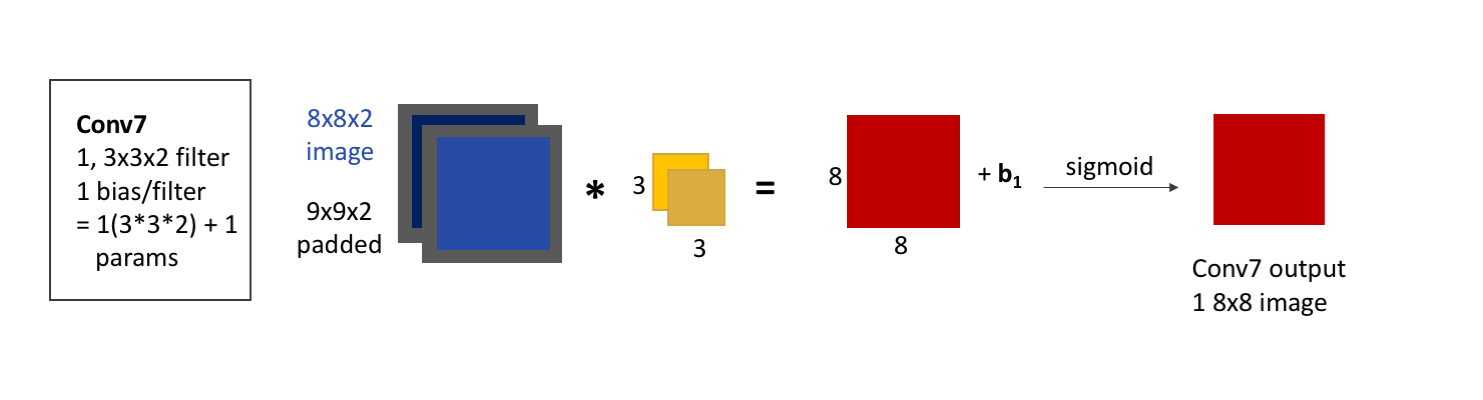

In [56]:
display(Im('%s/images/layers/conv7.png' %filepath, height=270, width=1000))

Adding this to our model:

In [0]:
conv7 = Conv2D(1, 3, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv6) # note the change in activation function

<a id="4.7"></a>
**<font size="4"> 4.7 The Final Model**</font>

Now, let's finish putting the model together, and have a look at the model summary that keras gives us, and try it out.

To finish up our model, we just need to define it by telling keras what layer is the input and what is the output. We'll also need to compile the model before we can use it, where we'll get to choose a few hyperparameters. To keep it simple, we'll choose a common optimizer, the **Adam** optimizer, and only specify the **learning rate**. We also need to choose what loss function to use, and we'll use the **mean-squared error**, which keras already has built in for us.

This tutorial isn't meant to cover the huge body of options for all of these hyperparameters, loss functions, and other functionalities that we can add when compiling our model, but the keras website: https://keras.io/models/model/ does a good job of listing all of the options it has for the compile method.

In [58]:
simple_model = Model(input = inputs, output = conv7) # we tell it that the first layer is the input layer, and that conv7 is going to be
                                                     # the layer that gives us the output. All of the layers in between were connected as we defined
                                                     # them, so we don't need to give the model any of those here.

simple_model.compile(optimizer = Adam(lr = .0005), # Adam is an extremely common optimizer, and the lr is the learning rate
                   loss = 'mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.


Keras will also display for us a summary of our model, showing the different layers, their shapes, and the number of learnable parameters per layer, and is a handy way to make sure that the model is consistent and doing everything we expect it to.

In [59]:
simple_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 2)      20          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 2)      38          conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 2)      0           conv2d_2[0][0]                   
____________________________________________________________________________________________

We can see, if we go back and check the number of learnable parameters, and the output shapes for each of these layers, that they match exactly what we expected. The fact that the model compiles properly is good news, too - we'll get an error if we tried to build a model that doesn't connect properly or where the shapes don't make sense.

Training a model in keras is also super simple. Let's try training this model, on our example data, for 500 **epochs** - 500 iterations of the model seeing all of the example images and adjusting the weights accordingly.



In [60]:
simple_model_history = simple_model.fit(X_example, y_example,   # the fake data we made, X is input, y is output
                                        epochs = 500,           # we'll try out 100 epochs
                                        verbose = 1)            # verbose = 1 tells keras that we want to see how well the model is doing at every epoch




Epoch 1/500





100/100 [==============================] - 15s 154ms/step - loss: 0.4256
Epoch 2/500
100/100 [==============================] - 0s 247us/step - loss: 0.4156
Epoch 3/500
100/100 [==============================] - 0s 235us/step - loss: 0.4049
Epoch 4/500
100/100 [==============================] - 0s 235us/step - loss: 0.3936
Epoch 5/500
100/100 [==============================] - 0s 256us/step - loss: 0.3821
Epoch 6/500
100/100 [==============================] - 0s 258us/step - loss: 0.3702
Epoch 7/500
100/100 [==============================] - 0s 224us/step - loss: 0.3589
Epoch 8/500
100/100 [==============================] - 0s 230us/step - loss: 0.3477
Epoch 9/500
100/100 [==============================] - 0s 242us/step - loss: 0.3374
Epoch 10/500
100/100 [==============================] - 0s 239us/step - loss: 0.3278
Epoch 11/500
100/100 [==============================] - 0s 247us/step - loss: 0.3189
Epoch 12/500
100/100 [==============================] - 0s 243us/

So, how did the model do? Let's check by using the im_in and im_out example images that we made at the start of this section, which the model hasn't seen before, to see if it can do the inversion for us.

(<matplotlib.image.AxesImage at 0x7fc3684d2320>,
 Text(0.5, 1.0, 'Predicted Output'))

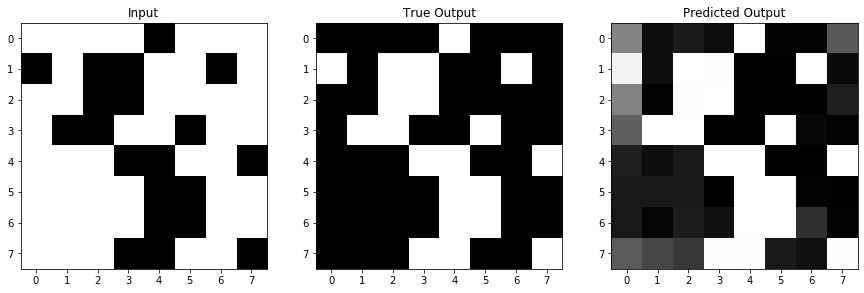

In [61]:
fig = plt.figure(figsize=(15,5))
ax1,ax2,ax3 = fig.subplots(1,3)

predicted_im_out = simple_model.predict(im_in.reshape(1,8,8,1)).reshape(8,8)   # even though our image was 8x8 to begin with, keras needs the 
                                                                               # shape to match the input shape it expected, so we have to reshape twice

ax1.imshow(im_in, cmap="Greys"), ax1.set_title("Input")
ax2.imshow(im_out, cmap="Greys"), ax2.set_title("True Output")
ax3.imshow(predicted_im_out, cmap="Greys"), ax3.set_title("Predicted Output")

It doesn't do too bad! You can rerun the last 2 cells, training the model for another 500 epochs (it will keep training what it currently has instead of training all over again, unless you re-run model.compile()), and check if it does even better (spoiler: it does). But either way, let's move on and look at exactly what's happening under the hood of this network a little more closely.

<a id="5"></a>
<font size="5">**5. Interpreting Filters**</font>

So far, we've been talking in detail about what a UNet does in a more conceptual way. But now that we've built a real example, let's take a closer look at how real data is transformed by a real model. Then, we'll build a model for a real-world problem, and try to see how much we can visualize and understand from a model doing a much more complicated transformation.

<a id="5.1"></a>
**<font size="4"> 5.1 Our Simple Example**</font>

The simple inversion example that we did didn't have many layers or filters. So, we can actually go through and easily look at every single weight our model learned.

Keras saves the weights that all of our filters had, so it's easy to go through and display all of our model's filters:

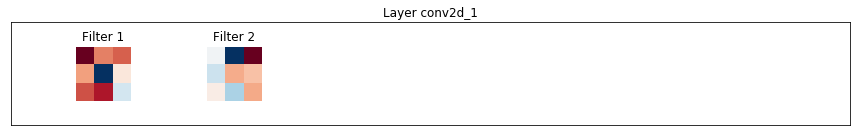

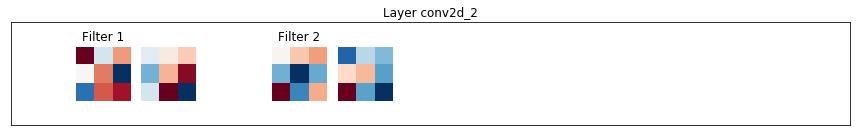

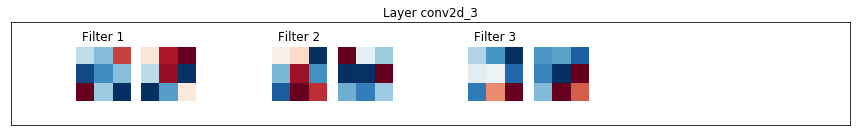

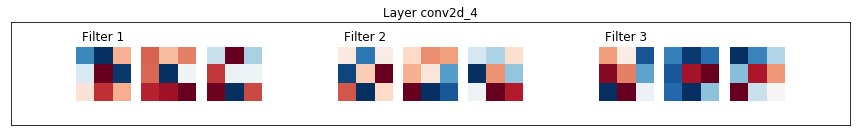

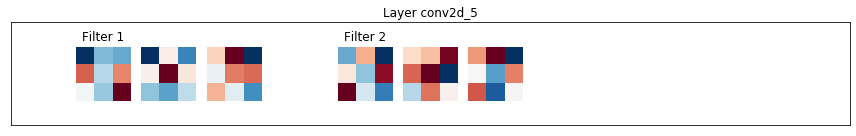

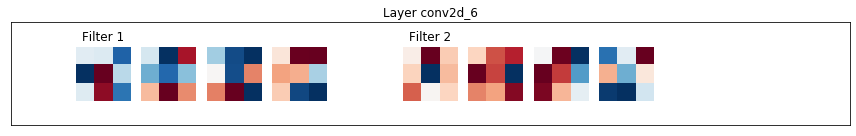

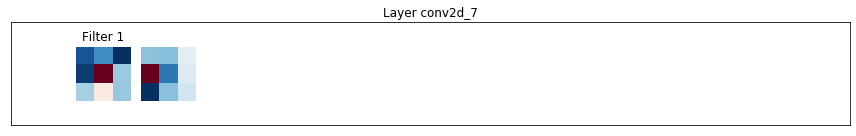

In [62]:
# iterate over all of our layers
for layer in simple_model.layers:
  if "conv" in layer.name:       # there are other (non-conv) layers, with no learnable params
    filters, biases = layer.get_weights()            # filters will have shape (filter_size, filter_size, number channels, number filter)
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)    # normalize all filters for one layer

    # set up one figure per layer
    fig = plt.figure(figsize=(12,2))
    plt.title("Layer %s" %(layer.name)), plt.xticks([]), plt.yticks([]) # say what layer we're on, and box in layers (but without axis ticks)
    fig_count = 1    # to keep track of subplots

    # Iterate over all the filters in the layer
    for i in range(filters.shape[-1]):    # 'i' will iterate over the number of filters in that layer
      ax = fig.add_subplot(1,13,fig_count), plt.axis('off')    # this adds a dummy subplot, just to leave some whitespace between new filters
      fig_count += 1
      for j in range(filters.shape[-2]):      # 'j' will iterate over the channels of the filter
        ax = fig.add_subplot(1,13,fig_count)  # make a new subplot per channel per filter
        if j == 0:
          ax.set_title("Filter %d" %((i+1)))  # only title the first channel of the filter, to keep it neat
        plt.imshow(filters[:,:,j,i],cmap='RdBu'), plt.axis('off')
        fig_count += 1
    plt.tight_layout()

Looking at all of our filters *can* be useful, but it also can show us a bunch of seemingly random weights, as it does above. What's often more useful is to look at the layer **activations** - or the "version" of the image that convoling with a filter, adding its bias, and passing through an activation function gives us. For each of the filters above, we can look at the activation that would come from convolving an image with it.

So, let's use our example image again, and see what the activations for that image are at each layer.

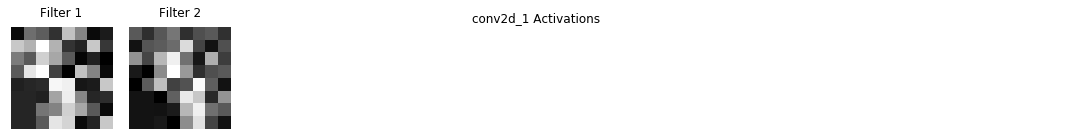

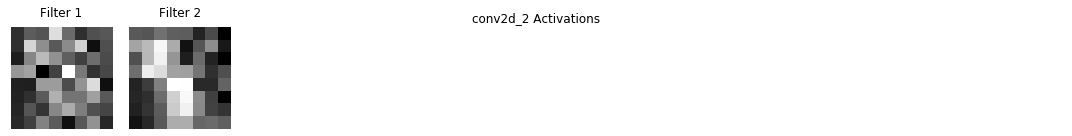

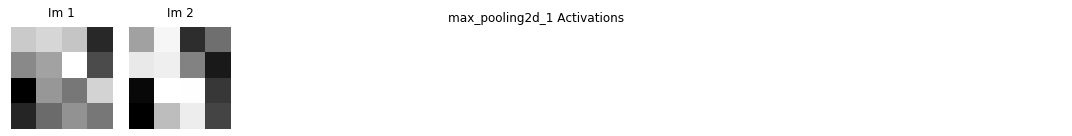

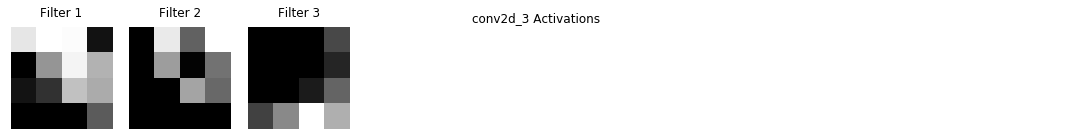

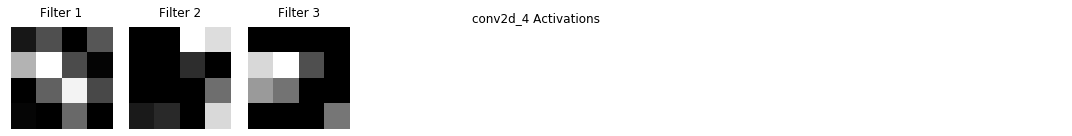

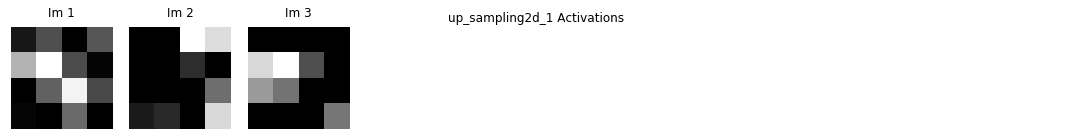

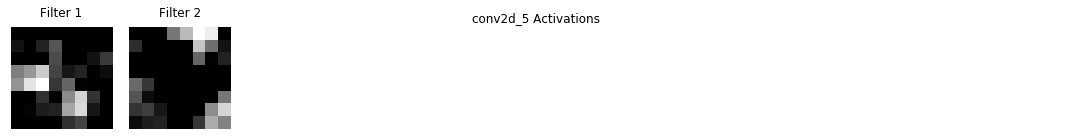

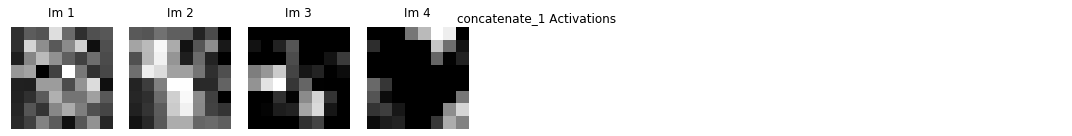

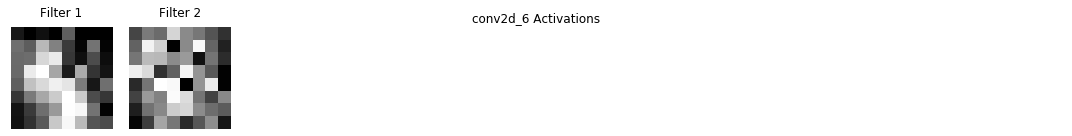

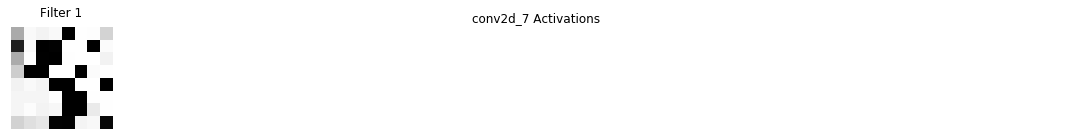

In [63]:
layer_outputs = [layer.output for layer in simple_model.layers[1:]]     # the first layer is input, but we want all layers after that
activation_model = Model(inputs=simple_model.input, outputs=layer_outputs)    # Make a model that returns each layer output given the input
activations = activation_model.predict(im_in.reshape(1,8,8,1))    # then, get all the activations for our test image


for layer_num in range(len(activations)):
  layer_activation = activations[layer_num]
  fig = plt.figure(figsize = (15,2*np.ceil(layer_activation.shape[-1]/9)))
  plt.title("%s Activations" %simple_model.layers[layer_num+1].name)
  plt.axis('off')
  for filter_num in range(layer_activation.shape[-1]):
    ax = fig.add_subplot(np.ceil(layer_activation.shape[-1]/9), 9, filter_num+1)
    ax.matshow(layer_activation[0, :, :, filter_num], cmap='Greys_r')
    if "conv" in simple_model.layers[layer_num+1].name:
      ax.set_title("Filter %d" %(filter_num+1))    # only have filters in the conv layers, else just call them Im 1/2/etc..
    else:
      ax.set_title("Im %d" %(filter_num+1))
    plt.axis('off')
  plt.tight_layout()

So, those aren't exactly interesting either. There are a few things to point out here:

*   The pooling, upsampling, and concatenate "activations" (there's no activation function in these layers so the name doesn't make as much sense for them) are plotted, so you can confirm these operations are acting as we expect.
*   Because the activations are after the different channels of the filter have summed, we are showing one image per *filter*, not one image per filter channel.


But, even though we can look at all of our weights and activations, we aren't getting too much insight here on how our image is being inverted by these operations. A big part of this could be because the task we're asking the U-Net to perform - inverting an image - doesn't actually care too much about the features in the image. It isn't like identifying an eye to figure out that you're looking at a face - each pixel in this case could be inverted completely independently from those around it.

<a id="5.2"></a>
**<font size="4"> 5.2 A Real-World Example**</font>

So instead, let's take a look at a real-world example, where the features of the image are much more important, and try to see what we can learn about what the U-Net is doing.

The example data and U-Net that we're going to be using are originally from: 

https://github.com/zhixuhao/unet

But we're going to augment the data differently, and I've made the U-Net smaller (in both number of layers and number of filters) to make it more manageable to visualize.

The task for this U-Net is image segmentation. Given a grayscale image, we want to create a black/white mask, where areas of interest are in black and all other areas are in white. Let's start by loading in the data so we can take a look at an example. We are also going to **augment** the data as we load it in. That means, we'll rotate and/or transpose images as we read them in, so that they can become multiple new images to use for training. We'll also chop each of our images (which begin as 512x512) into multiple smaller images, again, because smaller images will be easier to visualize later.

In [0]:
input_path = '%s/data/ims' %filepath
output_path = '%s/data/labels' %filepath

rotation_angles = [90,180,270]     # set degrees to rotate by, leave [] if no augmentation
mirror_angles = [Image.TRANSPOSE,Image.FLIP_LEFT_RIGHT,Image.FLIP_TOP_BOTTOM]    # set types of mirroring/transposing the image

sz = 512   # image sizes (one dimension specified, images must be square)
n_crops = 8   #  number of images (along one dimension) to crop original to. Will end up with n_crops*n_crops images for every original image

cropped_sz = int(sz/n_crops)  # size of image we want to crop to. sz/n_crops must be an integer to divide images evenly
sz = cropped_sz   # set the new size to the size of the cropped images

X = []
for file in np.sort(os.listdir(input_path)):
  full_im = Image.open('%s/%s' %(input_path, file))
  for i in range(n_crops):
    for j in range(n_crops):
      box = (i*cropped_sz,j*cropped_sz,(i+1)*cropped_sz,(j+1)*cropped_sz)    # get the region of the full image that will become the cropped image
      im = full_im.crop(box)
      X.append(np.array(im).reshape(sz,sz,1))
      for angle in rotation_angles:     # rotate images on all angles
        rotated_im = im.rotate(angle)
        X.append(np.array(rotated_im).reshape(sz,sz,1))  # add rotated im as new one
      for angle in mirror_angles:    # transpose images on all angles
        mirror_im = im.transpose(angle)
        X.append(np.array(mirror_im).reshape(sz,sz,1))  # add transposed im as new one

# build y in the same way as X, with images and rotations in the same order to they match each other
y = []
for file in np.sort(os.listdir(output_path)):
  full_im = Image.open('%s/%s' %(output_path, file))
  for i in range(n_crops):
    for j in range(n_crops):
      box = (i*cropped_sz,j*cropped_sz,(i+1)*cropped_sz,(j+1)*cropped_sz)
      im = full_im.crop(box)
      y.append(np.array(im).reshape(sz,sz,1))
      for angle in rotation_angles:
        rotated_im = im.rotate(angle)
        y.append(np.array(rotated_im).reshape(sz,sz,1))
      for angle in mirror_angles:
        mirror_im = im.transpose(angle)
        y.append(np.array(mirror_im).reshape(sz,sz,1))

input_size = X[0].shape

X = np.array(X)
y = np.array(y)

# scale data to a 0-1 range
X = (X-np.min(X))/(np.max(X)-np.min(X))
y = (y-np.min(y))/(np.max(y)-np.min(y))

Now let's look at some examples of our images, and confirm that our augmentations worked properly.

We now have 13440 pieces of data


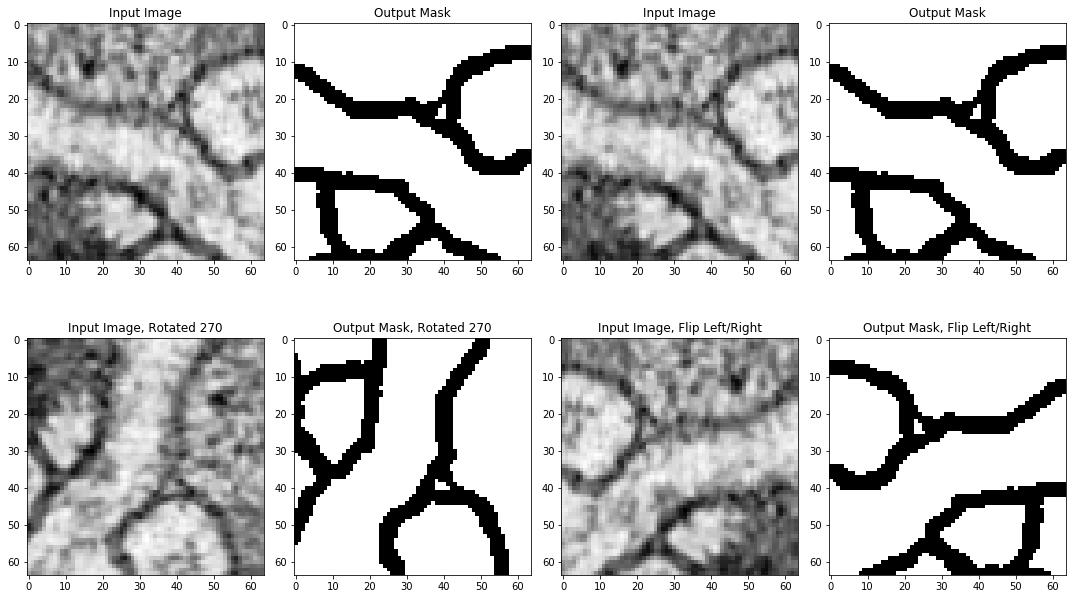

In [65]:
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(X[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image")
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(y[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask")
ax3 = fig.add_subplot(2,4,5)
ax3.imshow(X[3].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image, Rotated 270")
ax4 = fig.add_subplot(2,4,6)
ax4.imshow(y[3].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask, Rotated 270")
ax5 = fig.add_subplot(2,4,3)
ax5.imshow(X[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image")
ax6 = fig.add_subplot(2,4,4)
ax6.imshow(y[0].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask")
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(X[5].reshape(sz,sz),cmap='Greys_r'), plt.title("Input Image, Flip Left/Right")
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(y[5].reshape(sz,sz),cmap='Greys_r'), plt.title("Output Mask, Flip Left/Right")
plt.tight_layout()

print("We now have %d pieces of data" %len(X))

Now, let's build the model that we'll train on this problem. We're going to build this model exactly the same way that we built the very simple model, but it will have more layers and more filters.

In [66]:
inputs = Input(input_size)
# conv block 1
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# conv block 2
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# conv block 3
conv3 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# conv block 4
conv4 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
# upconv block 1
up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
concat7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat7)
conv7 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
# upconv block 2
up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
concat8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
# upconv block 3
up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
concat9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
# output
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 16)   2320        conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_9[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Let's train this model:

<font size="2"> *Note: this model is a bit more complicated than our very simple one, so this cell could take some time to run.*

In [67]:
model_history = model.fit(X, y, epochs = 100, verbose = 1,batch_size=100)

Epoch 1/100
13440/13440 [==============================] - 13s 951us/step - loss: 0.1271 - acc: 0.8048
Epoch 2/100
13440/13440 [==============================] - 10s 725us/step - loss: 0.1084 - acc: 0.8543
Epoch 3/100
13440/13440 [==============================] - 10s 727us/step - loss: 0.1045 - acc: 0.8678
Epoch 4/100
13440/13440 [==============================] - 10s 730us/step - loss: 0.1014 - acc: 0.8769
Epoch 5/100
13440/13440 [==============================] - 10s 737us/step - loss: 0.0985 - acc: 0.8839
Epoch 6/100
13440/13440 [==============================] - 10s 737us/step - loss: 0.0959 - acc: 0.8895
Epoch 7/100
13440/13440 [==============================] - 10s 740us/step - loss: 0.0938 - acc: 0.8932
Epoch 8/100
13440/13440 [==============================] - 10s 745us/step - loss: 0.0915 - acc: 0.8972
Epoch 9/100
13440/13440 [==============================] - 10s 745us/step - loss: 0.0897 - acc: 0.9000
Epoch 10/100
13440/13440 [==============================] - 10s 749us/ste

Now, before we take a closer look at what the model is doing, let's look at how accurately it was able to produce our desired masks to see if we've sucessfully completed our task.

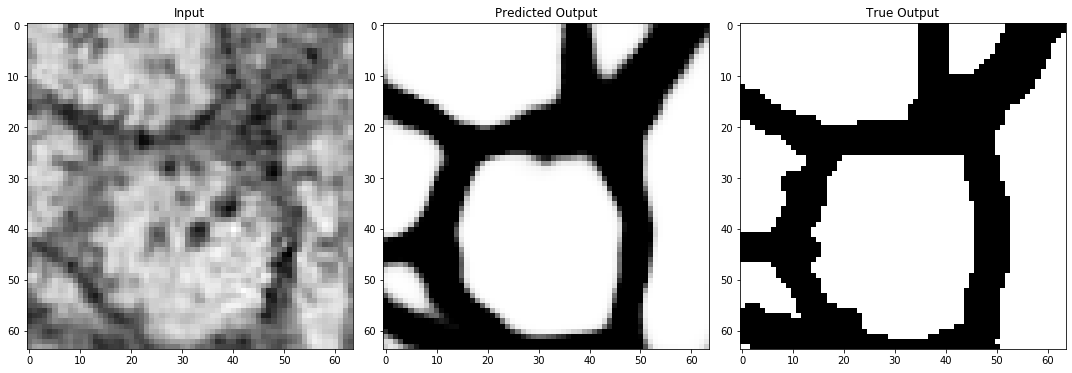

In [77]:
data_num = 2500  # can change to look at a different image and its prediction

input_im = X[data_num].reshape(sz,sz)
predicted_im = model.predict(X[data_num:data_num+1]).reshape(sz,sz)
output_im = y[data_num].reshape(sz,sz)

fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
ax1.imshow(input_im,cmap='Greys_r'), ax1.set_title("Input")
ax2.imshow(predicted_im,cmap='Greys_r'), ax2.set_title("Predicted Output")
ax3.imshow(output_im,cmap='Greys_r'), ax3.set_title("True Output")
plt.tight_layout()

And it looks pretty good! Okay, so let's look at the filters again for this network, and see if any of them seem to stand out as picking out some features for us. 

We'll do this in the exact same way that we did above, except we'll only look at the filters for the **first** convolutional layer of the **first** convolutional block. This is because we have way more filters in this example than we did in the last example, so even in the second convolution of the first convolution block involves filters with 16 channels, so visualizing all of them would be extremely hard.

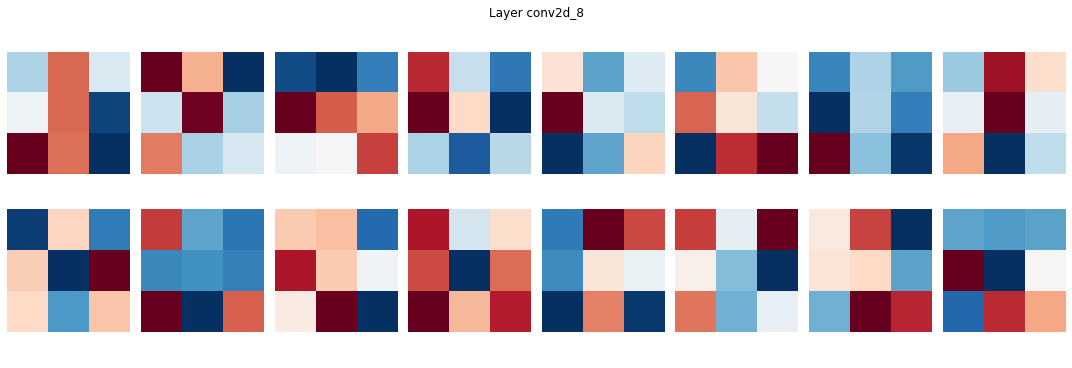

In [90]:
for layer in model.layers[1:2]:
  if "conv" in layer.name:
    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig = plt.figure(figsize=(15,5))
    plt.title("Layer %s" %layer.name)
    plt.axis('off')
    for i in range(filters.shape[-1]):
      ax = fig.add_subplot(np.ceil(filters.shape[-1]/8),8,i+1)
      plt.imshow(filters[:,:,:,i].reshape(filters.shape[0],filters.shape[1]),cmap='RdBu')
      plt.axis('off')
    plt.tight_layout()

It might not be any more evident in this real-world example than it was in our very simple example what these filters are doing. But, now that our images have significant structure, we might be able to figure out what these filters are telling us. Let's look at the activations for this first convolutional layer to see if anything jumps out.

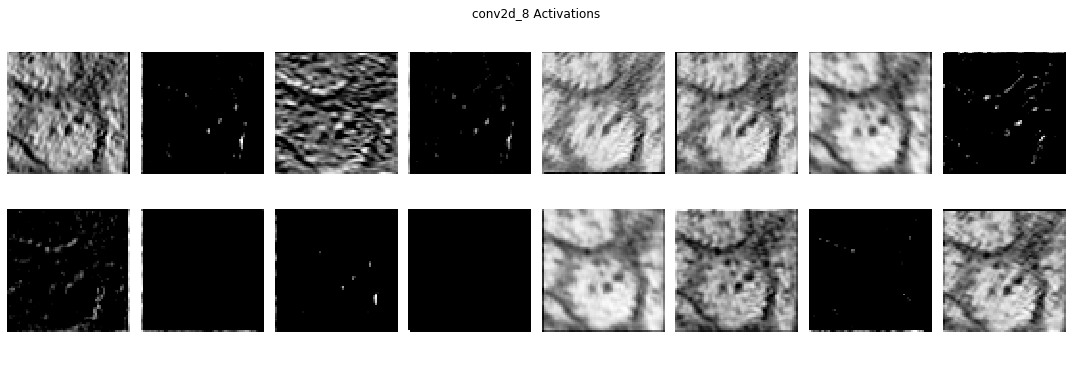

In [91]:
layer_outputs = [layer.output for layer in model.layers[1:]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(input_im.reshape(1,64,64,1)) 

for layer_num in range(1):
  layer_activation = activations[layer_num]
  fig = plt.figure(figsize = (15,5))
  plt.title("%s Activations" %model.layers[layer_num+1].name)
  plt.axis('off')
  for filter_num in range(layer_activation.shape[-1]):
    ax = fig.add_subplot(np.ceil(layer_activation.shape[-1]/8), 8, filter_num+1)
    ax.imshow(layer_activation[0, :, :, filter_num], cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()

Now, if you've just been reading the cells of this notebook without re-running them, you have the same filters and activations as I do. Otherwise, if you've been re-running the cells, and you've re-trained the model, your filters and activations will be different than mine. But, you should see that the activations all look like versions of the image that are meant to pick out *something*.

In the cells below, I'm going to manually load in some of the filters and activations that I have in my notebook, and talk about them. If you didn't re-run the notebook, this will be filters and activations 2,6, and 7 (python-indexed) from above. Otherwise, your filters and activations will be different, but likely some will still be relatively similar, to mine.

So, here are the filters we're going to look at:

(<matplotlib.image.AxesImage at 0x7fc25eaab0b8>, Text(0.5, 1.0, 'Filter 3'))

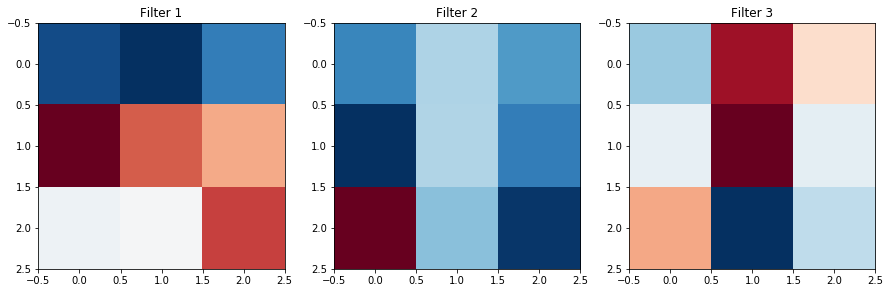

In [95]:
filt_2 = np.array([[0.6744713 , 0.69218516, 0.6413911 ],
                   [0.36131164, 0.426186  , 0.4645831 ],
                   [0.534594  , 0.5280584 , 0.4137286 ]])

filt_6 = np.array([[0.7352305,  0.61722165, 0.70441914],
                   [0.85438216, 0.61504716, 0.7480632 ],
                   [0.16859733, 0.65413386, 0.84601194]])

filt_7 = np.array([[0.6218604,  0.25640523, 0.45756572],
                   [0.5342595,  0.20999649, 0.53925157],
                   [0.3942946,  0.810168,   0.5870034 ]])

fig = plt.figure(figsize=(15,5))
ax1,ax2,ax3 = fig.subplots(1,3)
ax1.imshow(filt_2,cmap='RdBu'), ax1.set_title("Filter 1")
ax2.imshow(filt_6,cmap='RdBu'), ax2.set_title("Filter 2")
ax3.imshow(filt_7,cmap='RdBu'), ax3.set_title("Filter 3")

Now, let's look at the activations these filters gave:

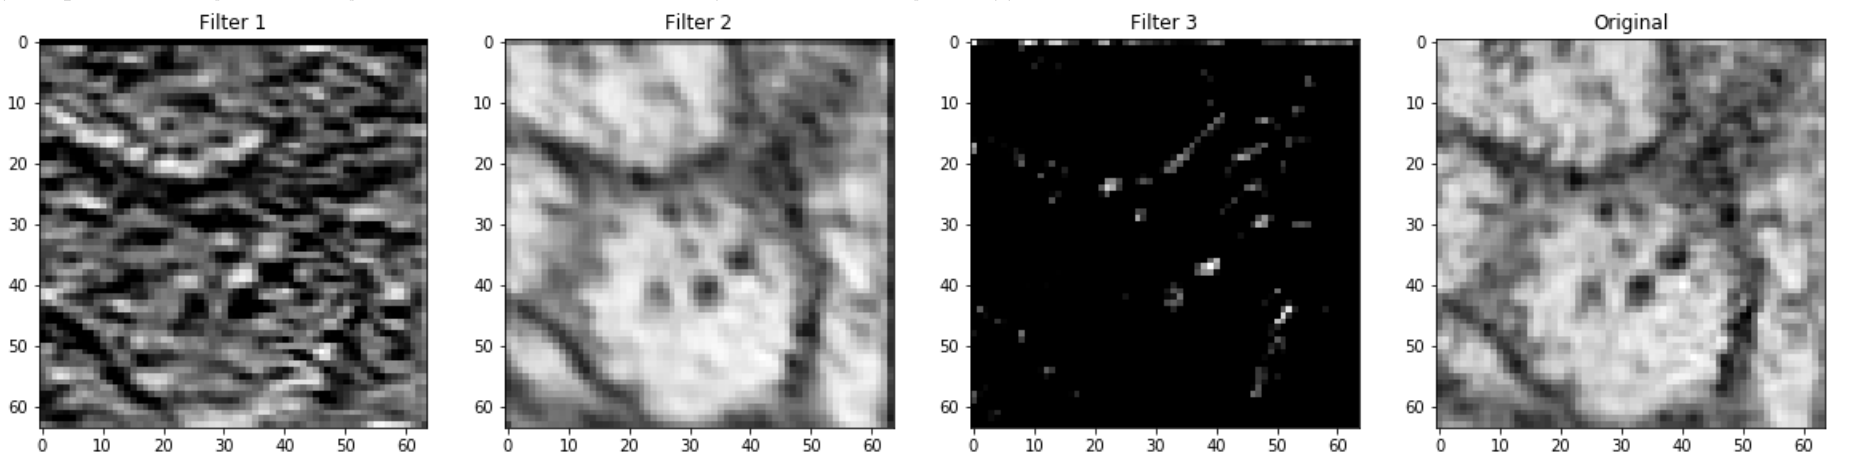

In [22]:
display(Im('%s/images/realWorld_example_activations.png' %filepath, height=270, width=1000))

So, let's try to speculate what these filters might be doing.  

*   Filter #1 looks like it might be a horizontal/diagonal edge detector. It seems to pick out the strongest borders between black and and white pixels in the original image, provided that border isn't vertical.
*   Filter #2 doesn't seem to change the image significantly, besides blurring it somewhat to smooth out the lighter sections.
*   Filter #3 seems to only emphasize the darkest regions of the original image: the highest concentration of black pixels in the original image are highlighted, and the rest of the image is uniform.

If we go back and look at our filters, is there any evidence that this is what they're doing? Well, maybe. If you look at the structure of them, you can pick out that Filter #1 might have differing values horizontally/diagonally which might be giving us the horizontal edges, or that Filter #2 might be keeping information from all the cells about equally which blurs the image out, but it's easier to look at the activation and say what it's doing based off of that than to make guesses based on the weights.


<a id='#5.3'></a>
**<font size="4"> 5.3 Deeper Layers**</font>

And what about the deeper layers?

Well, the activations are easy enough to visualize. Although in the layers with 64 or 128 filters, this would mean looking at 128 images, that's much easier than trying to look at the filters, which will end up with 128 channels.

However, it can prove more challenging to interpret later activations because they are now convolved versions of already convolved versions of our images. So while these activations can still provide valuable insight at every level, it's difficult to straightforwardly interpret what *exactly* the UNet is doing.

Still, it's clearly an incredibly powerful tool for image transformation, which hopefully you now have a little better of an understanding/intuition about!